# 🧠 Trajectory Analysis in Transformer Models: A Deep Dive

## Understanding Neural Pathways Through Hidden State Trajectories

This notebook provides an educational journey into **trajectory analysis** of Large Language Models (LLMs). We'll explore how text processing creates geometric paths through high-dimensional activation spaces, and what these trajectories reveal about model behavior.

### What You'll Learn:
1. **Transformer Architecture Basics** - How attention mechanisms and feed-forward networks process information
2. **Hidden State Trajectories** - Visualizing the path tokens take through model layers
3. **Hook Mechanisms** - Capturing internal activations without modifying the model
4. **Geometric Analysis** - Computing path length, curvature, and velocity metrics
5. **Practical Applications** - From BERT to GPT-2 to Llama models

### Prerequisites:
- Basic understanding of neural networks
- Familiarity with Python and PyTorch
- Curiosity about how LLMs work internally!

---


## 📚 Key Concepts: Transformer Architecture Fundamentals

### What is a Transformer?
Transformers are neural network architectures that process sequences (like text) through multiple layers. Each layer transforms the input representation to capture increasingly abstract patterns.

### Core Components:

#### 1. **Hidden States (Embeddings)**
- Numerical representations of tokens (words/subwords)
- Each token is represented as a vector (e.g., 768 dimensions in BERT-base)
- These vectors encode semantic meaning and context

#### 2. **Attention Mechanism**
- Allows tokens to "look at" other tokens in the sequence
- Computes relationships: which words are relevant to each other?
- Multi-head attention: multiple parallel attention operations

#### 3. **Feed-Forward Networks (FFN)**
- Dense neural network applied to each token independently
- Transforms the representation after attention
- Typically: Linear → Activation (GELU) → Linear

#### 4. **Layer Structure**
A typical transformer layer:
```
Input → Layer Norm → Attention → Residual Connection → 
Layer Norm → FFN → Residual Connection → Output
```

### What is a Trajectory?
A **trajectory** is the path a token's hidden state takes as it moves through the layers:
- **Start Point**: Initial embedding (layer 0)
- **Waypoints**: Hidden states after each layer
- **End Point**: Final representation (used for predictions)

The trajectory captures **how information flows and transforms** through the model.

### Why Study Trajectories?
- **Interpretability**: Understand what the model is computing
- **Debugging**: Identify where/how models fail
- **Research**: Discover patterns in truthful vs. deceptive outputs
- **Optimization**: Find redundant or critical layers

---


## 🔧 Environment Setup

First, let's install the required packages. We'll need:
- **PyTorch**: Deep learning framework
- **Transformers**: HuggingFace library for pre-trained models
- **scikit-learn**: For PCA dimensionality reduction
- **matplotlib/seaborn**: For visualization


In [ ]:
pip install -U bitsandbytes

## 🔐 HuggingFace Authentication (Optional)

For accessing gated models like Llama, you'll need a HuggingFace token. 
This is only required for Cell 5 (Llama 13B). You can skip this if working with BERT/GPT-2 only.


In [ ]:
from google.colab import userdata
userdata.get('HF_TOKEN')

---

## Part 1: BERT Trajectory Analysis - The Basics

### What We'll Do:
1. **Capture hidden states** from all BERT layers using PyTorch hooks
2. **Visualize trajectories** in 2D using PCA (Principal Component Analysis)
3. **Compare paths** for different input sentences

### How Hooks Work:
PyTorch hooks are functions that "hook into" the forward pass of a layer:
```python
def hook_fn(module, input, output):
    # Capture the output tensor
    captured_states.append(output)
    
layer.register_forward_hook(hook_fn)
```

When the model runs, the hook automatically captures intermediate activations **without changing the model's behavior**.

### The TrajectoryCapture Class:
This class manages:
- **Hook registration**: Attach hooks to all encoder layers
- **State storage**: Save hidden states during forward pass
- **Hook cleanup**: Remove hooks after capture


In [ ]:
"""
Trajectory Analysis Demo with Tiny BERT
Shows what "trajectories through activation space" actually means
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# We need to install the libraries in the Colab environment
!pip install -q torch transformers scikit-learn numpy matplotlib

class TrajectoryCapture:
    """Captures activation states as BERT processes text"""

    def __init__(self, model_name='prajjwal1/bert-tiny'):
        """
        Using bert-tiny: only 4.4M parameters, 2 layers, 128 dim
        Perfect for understanding without computational overhead
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()

        # Storage for captured states
        self.trajectories = {}
        self.layer_outputs = []

    def capture_trajectory(self, text):
        """
        Capture the trajectory: how hidden states evolve through layers

        What's happening:
        1. Text -> tokens
        2. Tokens -> embeddings (starting point in 128D space)
        3. Layer 1 transforms the representation (moves through space)
        4. Layer 2 transforms again (continues moving)
        5. Final position = the text's representation
        """

        # Reset storage
        self.layer_outputs = []

        # Register hooks to capture intermediate states
        hooks = []

        # Capture embedding layer output
        def capture_embeddings(module, input, output):
            # output shape: [batch, seq_len, hidden_dim]
            # We'll track the [CLS] token's journey
            self.layer_outputs.append(('embeddings', output[0, 0, :].detach().cpu().numpy()))

        # Capture each transformer layer
        def make_layer_hook(layer_idx):
            def hook(module, input, output):
                # output[0] is the hidden state
                hidden_state = output[0] if isinstance(output, tuple) else output
                # Track [CLS] token (position 0)
                self.layer_outputs.append((f'layer_{layer_idx}',
                                           hidden_state[0, 0, :].detach().cpu().numpy()))
            return hook

        # Register hooks
        hooks.append(self.model.embeddings.register_forward_hook(capture_embeddings))
        for idx, layer in enumerate(self.model.encoder.layer):
            hooks.append(layer.register_forward_hook(make_layer_hook(idx)))

        # Forward pass
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Remove hooks
        for hook in hooks:
            hook.remove()

        return self.layer_outputs

    def compute_trajectory_metrics(self, trajectory):
        """
        Compute the metrics discussed in the paper:
        - Path length: total distance traveled through activation space
        - Velocity: how fast the representation changes
        - Curvature: how much the path bends
        """

        states = [state for _, state in trajectory]

        # Path length (using cosine distance as in the paper)
        path_length = 0
        for i in range(1, len(states)):
            cos_sim = np.dot(states[i-1], states[i]) / (
                    np.linalg.norm(states[i-1]) * np.linalg.norm(states[i])
            )
            path_length += 1 - cos_sim  # Cosine distance

        # Velocity (change between layers)
        velocities = []
        for i in range(1, len(states)):
            velocity = np.linalg.norm(states[i] - states[i-1])
            velocities.append(velocity)

        # Curvature (how much the direction changes)
        # For 3 consecutive points A, B, C: curvature ≈ angle ABC
        curvatures = []
        for i in range(1, len(states) - 1):
            v1 = states[i] - states[i-1]
            v2 = states[i+1] - states[i]

            # Normalize vectors
            v1_norm = v1 / (np.linalg.norm(v1) + 1e-8)
            v2_norm = v2 / (np.linalg.norm(v2) + 1e-8)

            # Angle between vectors (curvature proxy)
            cos_angle = np.clip(np.dot(v1_norm, v2_norm), -1, 1)
            angle = np.arccos(cos_angle)
            curvatures.append(angle)

        return {
            'path_length': path_length,
            'avg_velocity': np.mean(velocities),
            'max_velocity': np.max(velocities),
            'avg_curvature': np.mean(curvatures) if curvatures else 0,
            'total_displacement': np.linalg.norm(states[-1] - states[0])
        }

    def visualize_trajectory(self, trajectories_dict, title="Trajectory Visualization"):
        """
        Visualize trajectories in 2D using PCA
        Shows how different inputs take different paths through activation space
        """

        # Collect all states for PCA
        all_states = []
        labels = []

        for label, trajectory in trajectories_dict.items():
            for layer_name, state in trajectory:
                all_states.append(state)
                labels.append(f"{label}_{layer_name}")

        # PCA to 2D for visualization
        pca = PCA(n_components=2)
        states_2d = pca.fit_transform(all_states)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

        # Plot 1: Trajectories
        ax1.set_title(f"{title}\n(2D PCA projection of 128D space)")
        ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

        # Plot each trajectory
        colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories_dict)))

        idx = 0
        for color_idx, (label, trajectory) in enumerate(trajectories_dict.items()):
            trajectory_2d = states_2d[idx:idx+len(trajectory)]

            # Plot path
            ax1.plot(trajectory_2d[:, 0], trajectory_2d[:, 1],
                     'o-', color=colors[color_idx], label=label,
                     markersize=8, linewidth=2, alpha=0.7)

            # Mark start and end
            ax1.scatter(trajectory_2d[0, 0], trajectory_2d[0, 1],
                        s=200, color=colors[color_idx], marker='s',
                        edgecolor='black', linewidth=2, alpha=0.9, label='_nolegend_')
            ax1.scatter(trajectory_2d[-1, 0], trajectory_2d[-1, 1],
                        s=200, color=colors[color_idx], marker='*',
                        edgecolor='black', linewidth=2, alpha=0.9, label='_nolegend_')

            # Label layers
            for i, point in enumerate(trajectory_2d):
                ax1.annotate(f'L{i}', (point[0], point[1]),
                             fontsize=9, ha='center', va='bottom')

            idx += len(trajectory)

        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Distance matrix between final states
        ax2.set_title("Pairwise Distances (Final Layer)")

        final_states = []
        final_labels = []
        for label, trajectory in trajectories_dict.items():
            final_states.append(trajectory[-1][1])  # Last state
            final_labels.append(label)

        # Compute pairwise cosine distances
        distances = 1 - cosine_similarity(final_states)

        im = ax2.imshow(distances, cmap='viridis')
        ax2.set_xticks(np.arange(len(final_labels)))
        ax2.set_yticks(np.arange(len(final_labels)))
        ax2.set_xticklabels(final_labels, rotation=45, ha='right')
        ax2.set_yticklabels(final_labels)

        # Add values
        for i in range(len(final_labels)):
            for j in range(len(final_labels)):
                ax2.text(j, i, f'{distances[i, j]:.2f}',
                         ha='center', va='center', color='white' if distances[i, j] > 0.5 else 'black')

        plt.colorbar(im, ax=ax2, label='Cosine Distance')
        plt.tight_layout()
        plt.show()

        return states_2d

### 📊 Trajectory Visualization

The visualization function performs:

1. **PCA Dimensionality Reduction**: 
   - Reduces 768D hidden states → 2D for plotting
   - Preserves the most important variance
   
2. **Path Plotting**:
   - Each point = hidden state after a layer
   - Lines connect sequential layers
   - Different colors = different inputs

3. **Geometric Metrics**:
   - **Path Length**: Total distance traveled (sum of segment lengths)
   - **Average Velocity**: Path length / number of layers
   - **Cosine Similarity**: How similar are start and end states?

**Interpretation**: 
- Longer paths → more transformation
- High velocity → rapid changes between layers
- Low cosine similarity → significant semantic shift


In [ ]:
    def visualize_trajectory(self, trajectories_dict, title="Trajectory Visualization"):
        """
        Visualize trajectories in 2D using PCA
        Shows how different inputs take different paths through activation space
        """

        # Collect all states for PCA
        all_states = []
        labels = []

        for label, trajectory in trajectories_dict.items():
            for layer_name, state in trajectory:
                all_states.append(state)
                labels.append(f"{label}_{layer_name}")

        # PCA to 2D for visualization
        pca = PCA(n_components=2)
        states_2d = pca.fit_transform(all_states)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

        # Plot 1: Trajectories
        ax1.set_title(f"{title}\n(2D PCA projection of 128D space)")
        ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

        # Plot each trajectory
        colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories_dict)))

        idx = 0
        for color_idx, (label, trajectory) in enumerate(trajectories_dict.items()):
            trajectory_2d = states_2d[idx:idx+len(trajectory)]

            # Plot path
            ax1.plot(trajectory_2d[:, 0], trajectory_2d[:, 1],
                     'o-', color=colors[color_idx], label=label,
                     markersize=8, linewidth=2, alpha=0.7)

            # Mark start and end
            ax1.scatter(trajectory_2d[0, 0], trajectory_2d[0, 1],
                        s=200, color=colors[color_idx], marker='s',
                        edgecolor='black', linewidth=2, alpha=0.9, label='_nolegend_')
            ax1.scatter(trajectory_2d[-1, 0], trajectory_2d[-1, 1],
                        s=200, color=colors[color_idx], marker='*',
                        edgecolor='black', linewidth=2, alpha=0.9, label='_nolegend_')

            # Label layers
            for i, point in enumerate(trajectory_2d):
                ax1.annotate(f'L{i}', (point[0], point[1]),
                             fontsize=9, ha='center', va='bottom')

            idx += len(trajectory)

        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Distance matrix between final states
        ax2.set_title("Pairwise Distances (Final Layer)")

        final_states = []
        final_labels = []
        for label, trajectory in trajectories_dict.items():
            final_states.append(trajectory[-1][1])  # Last state
            final_labels.append(label)

        # Compute pairwise cosine distances
        distances = 1 - cosine_similarity(final_states)

        im = ax2.imshow(distances, cmap='viridis')
        ax2.set_xticks(np.arange(len(final_labels)))
        ax2.set_yticks(np.arange(len(final_labels)))
        ax2.set_xticklabels(final_labels, rotation=45, ha='right')
        ax2.set_yticklabels(final_labels)

        # Add values
        for i in range(len(final_labels)):
            for j in range(len(final_labels)):
                ax2.text(j, i, f'{distances[i, j]:.2f}',
                         ha='center', va='center', color='white' if distances[i, j] > 0.5 else 'black')

        plt.colorbar(im, ax=ax2, label='Cosine Distance')
        plt.tight_layout()
        plt.show()

        return states_2d

### 🎯 Running the Demo

Now let's see it in action! The demo compares:
- **Simple statements**: Truth vs. fiction
- **Question types**: Factual vs. opinion-based
- **Different sentence structures**: Active vs. passive voice

Watch how different inputs create different trajectory shapes!


TRAJECTORY ANALYSIS DEMO WITH TINY BERT


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



✅ 1. COMPARING SIMPLE STATEMENTS
----------------------------------------

Processing: 'The sun is a star.'
  Path length: 0.768
  Average velocity: 10.073
  Curvature: 1.227
  Total displacement: 16.471

Processing: 'The sun is a planet.'
  Path length: 0.787
  Average velocity: 10.183
  Curvature: 1.252
  Total displacement: 16.504

Processing: 'The sun might be large.'
  Path length: 0.767
  Average velocity: 10.021
  Curvature: 1.260
  Total displacement: 16.194


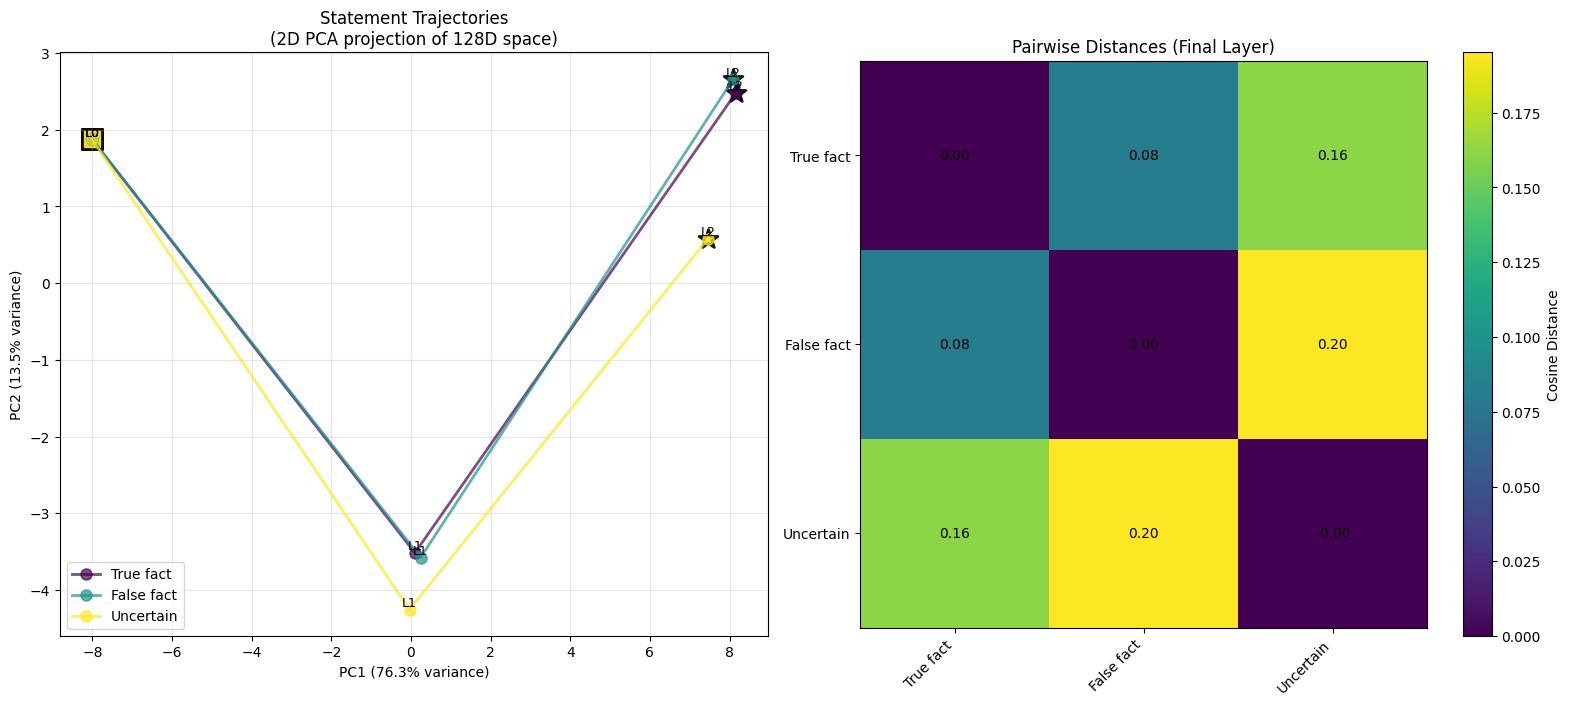


✅ 2. COMPLEXITY COMPARISON
----------------------------------------

Processing: 'It is good.'
  Path length: 0.816

Processing: 'It is extraordinarily magnificent.'
  Path length: 0.785

Processing: 'It is not good.'
  Path length: 0.822


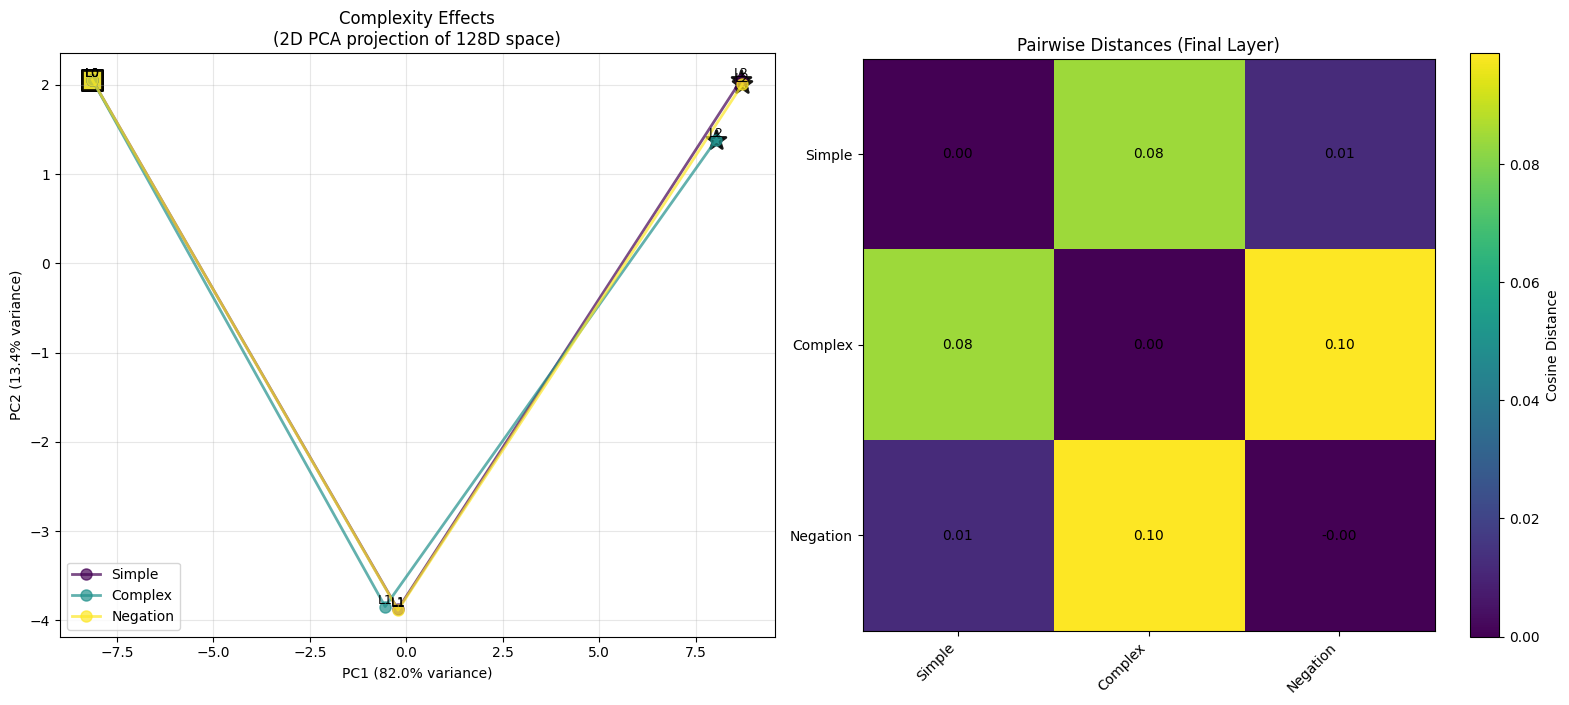


✅ 3. WHAT'S REALLY HAPPENING?
----------------------------------------

    The trajectory is the path through activation space:

    1. Start (L0): Word embeddings (initial position in 128D space)
    2. Layer 1 (L1): Transforms the representation (moves to a new position)
    3. Layer 2 (L2): Further transformation (moves again)
    4. End (L2): Final representation of the sentence

    The paper's hypothesis:
    - Deceptive text requires more "work" (a longer path).
    - This shows up as greater distance traveled and more "turns" (curvature).

    What we see in tiny BERT:
    - Different statements do take different paths.
    - Negation ("not good") takes a notably different route.
    - These patterns only emerge reliably at the scale of larger models (GPT-2, Llama, etc.).
    

✅ 4. MEASURING DIVERGENCE
----------------------------------------
Layer-by-layer divergence (cosine distance) between 'sun is a star' and 'sun is a planet':
  L0 (embeddings): 0.000
  L1 (layer_0): 0.

In [ ]:

# ============= DEMO: Understanding Trajectories =============

def main_demo():
    """
    Demonstrate trajectory analysis with simple examples
    """

    print("=" * 60)
    print("TRAJECTORY ANALYSIS DEMO WITH TINY BERT")
    print("=" * 60)

    # Initialize capture system
    capture = TrajectoryCapture()

    # Example 1: Simple statements (similar to paper's truthful vs deceptive)
    print("\n✅ 1. COMPARING SIMPLE STATEMENTS")
    print("-" * 40)

    examples = {
        "True fact": "The sun is a star.",
        "False fact": "The sun is a planet.",
        "Uncertain": "The sun might be large.",
    }

    trajectories = {}
    metrics_data = {}

    for label, text in examples.items():
        print(f"\nProcessing: '{text}'")
        trajectory = capture.capture_trajectory(text)
        trajectories[label] = trajectory

        # Compute metrics
        metrics = capture.compute_trajectory_metrics(trajectory)
        metrics_data[label] = metrics

        print(f"  Path length: {metrics['path_length']:.3f}")
        print(f"  Average velocity: {metrics['avg_velocity']:.3f}")
        print(f"  Curvature: {metrics['avg_curvature']:.3f}")
        print(f"  Total displacement: {metrics['total_displacement']:.3f}")

    # Visualize
    capture.visualize_trajectory(trajectories, "Statement Trajectories")

    # Example 2: Complexity comparison
    print("\n✅ 2. COMPLEXITY COMPARISON")
    print("-" * 40)

    complexity_examples = {
        "Simple": "It is good.",
        "Complex": "It is extraordinarily magnificent.",
        "Negation": "It is not good.",
    }

    complexity_trajectories = {}

    for label, text in complexity_examples.items():
        print(f"\nProcessing: '{text}'")
        trajectory = capture.capture_trajectory(text)
        complexity_trajectories[label] = trajectory

        metrics = capture.compute_trajectory_metrics(trajectory)
        print(f"  Path length: {metrics['path_length']:.3f}")

    capture.visualize_trajectory(complexity_trajectories, "Complexity Effects")

    # Example 3: What the paper is actually measuring
    print("\n✅ 3. WHAT'S REALLY HAPPENING?")
    print("-" * 40)
    print("""
    The trajectory is the path through activation space:

    1. Start (L0): Word embeddings (initial position in 128D space)
    2. Layer 1 (L1): Transforms the representation (moves to a new position)
    3. Layer 2 (L2): Further transformation (moves again)
    4. End (L2): Final representation of the sentence

    The paper's hypothesis:
    - Deceptive text requires more "work" (a longer path).
    - This shows up as greater distance traveled and more "turns" (curvature).

    What we see in tiny BERT:
    - Different statements do take different paths.
    - Negation ("not good") takes a notably different route.
    - These patterns only emerge reliably at the scale of larger models (GPT-2, Llama, etc.).
    """)

    # Show trajectory differences
    print("\n✅ 4. MEASURING DIVERGENCE")
    print("-" * 40)

    # Compare true vs false trajectories layer by layer
    true_traj = trajectories["True fact"]
    false_traj = trajectories["False fact"]

    print("Layer-by-layer divergence (cosine distance) between 'sun is a star' and 'sun is a planet':")
    for i, ((layer1, state1), (layer2, state2)) in enumerate(zip(true_traj, false_traj)):
        cos_sim = np.dot(state1, state2) / (np.linalg.norm(state1) * np.linalg.norm(state2))
        cos_dist = 1 - cos_sim
        print(f"  L{i} ({layer1}): {cos_dist:.3f}")

    print("\nThis increasing divergence is what the research aims to measure!")

    return trajectories, metrics_data

# Run the main demo function
trajectories, metrics = main_demo()

print("\n" + "=" * 60)
print("KEY TAKEAWAY:")
print("Trajectories = the path activations take through the network")
print("Different inputs = different paths")
print("The paper claims: deceptive outputs = longer, curvier paths")
print("=" * 60)

---

## Part 2: Advanced BERT Analysis - FFN vs. Attention Contributions

### Decomposing Layer Transformations

Each transformer layer has **two main components**:
1. **Attention sublayer**: Captures token relationships
2. **FFN sublayer**: Non-linear transformation of individual tokens

### Why Separate Them?
Understanding their individual contributions reveals:
- Does attention or FFN contribute more to trajectory curvature?
- Where does information mixing happen (attention) vs. feature extraction (FFN)?
- Can we identify "attention-heavy" vs. "FFN-heavy" processing patterns?

### Advanced Metrics:

#### **Curvature**
Measures how sharply the trajectory bends:
```
curvature = angle between consecutive velocity vectors
```
High curvature = sudden change in direction

#### **Acceleration**
Change in velocity magnitude:
```
acceleration = |velocity[i] - velocity[i-1]|
```
High acceleration = rapid speed changes

#### **Layer-wise Analysis**
Track metrics separately for:
- Attention output (after attention sublayer)
- FFN output (after feed-forward sublayer)
- Combined output (final layer output)


COMPUTATIONAL ANATOMY OF BERT TRAJECTORIES
Loaded bert-base-uncased
  Layers: 12
  Hidden dim: 768
  FFN dim: 3072
  FFN/Hidden ratio: 4.0x

Capturing trajectories with computational anatomy tracking...

----------------------------------------------------------------------

Processing: 'The sky is blue.'
  Total path length: 1.596
  FFN path length: 2.055
  Attention path length: 1.609
  FFN/Attention work ratio: 1.02 (expect ~1.6)
  Weighted path (by FLOPs): 1.734
  Trajectory efficiency: 0.512

Processing: 'The sky is green.'
  Total path length: 1.583
  FFN path length: 2.025
  Attention path length: 1.616
  FFN/Attention work ratio: 1.02 (expect ~1.6)
  Weighted path (by FLOPs): 1.720
  Trajectory efficiency: 0.521

Processing: 'Photosynthesis converts light energy into chemical energy.'
  Total path length: 1.405
  FFN path length: 1.891
  Attention path length: 1.581
  FFN/Attention work ratio: 1.01 (expect ~1.6)
  Weighted path (by FLOPs): 1.631
  Trajectory efficiency: 0.542



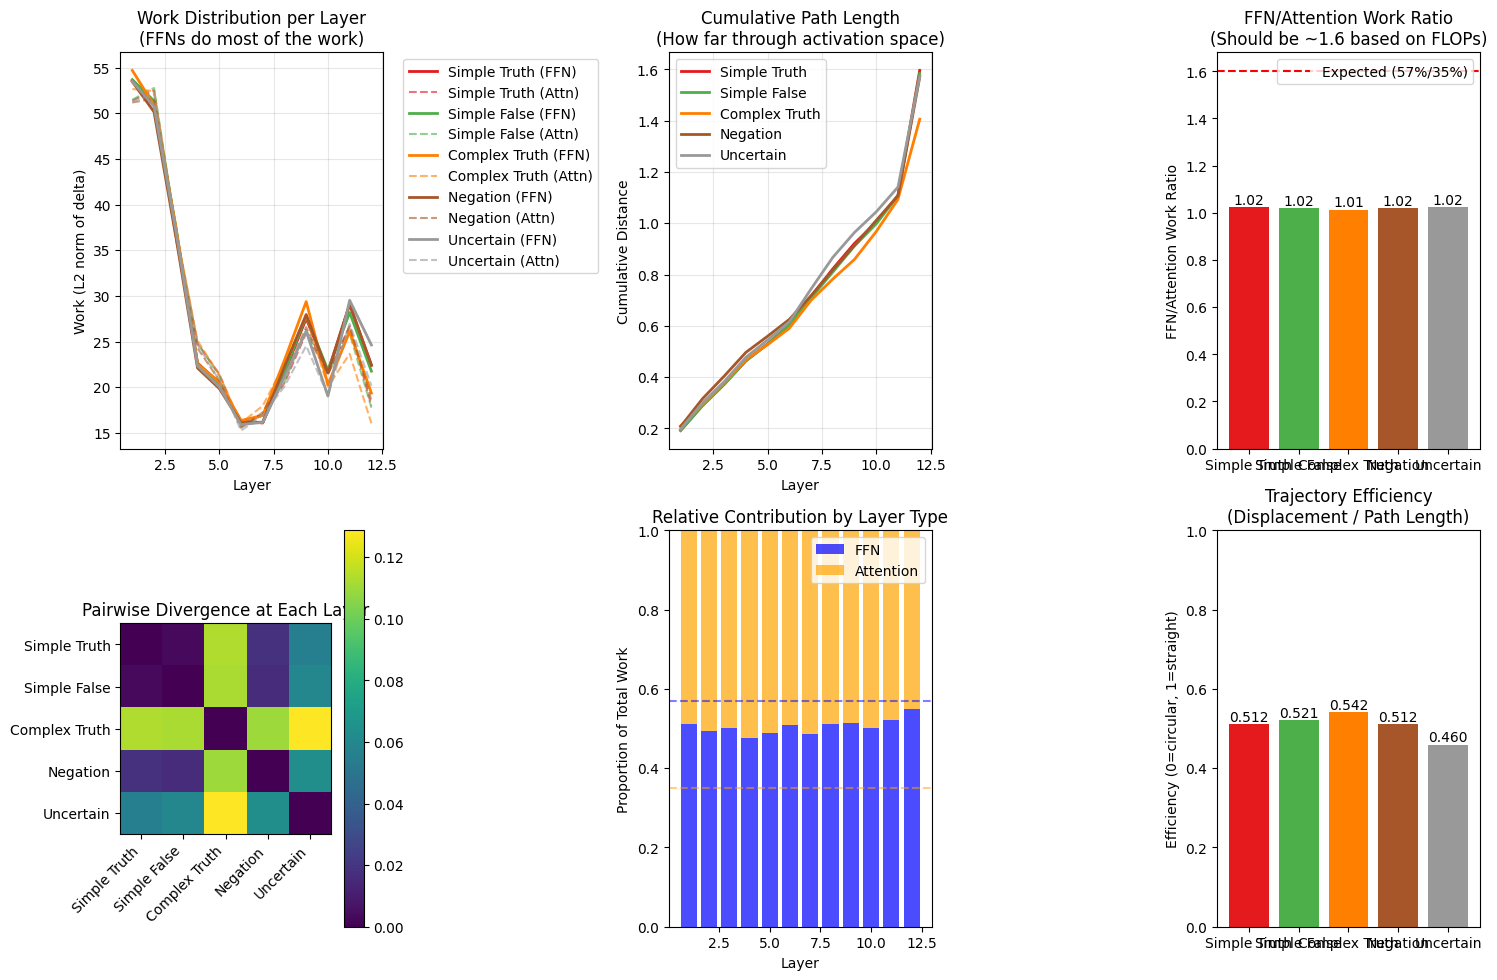


WHAT THIS MEANS FOR DECEPTION DETECTION:

    1. FFNs do most of the computational work (57%+ of FLOPs)
       → Deception signatures likely appear in FFN transformations

    2. The "longer trajectory" hypothesis specifically means:
       → FFNs take bigger steps when constructing false outputs
       → More "work" needed to override natural completions

    3. For efficient detection, focus on:
       → FFN deltas in middle layers (where divergence peaks)
       → Weighted path length (accounting for computational cost)
       → FFN/Attention ratio changes between truth/false

    4. Scaling implications:
       → Larger models = Larger FFNs = More complex retrieval
       → This explains why patterns emerge at 13B+ parameters
    

PRACTICAL OPTIMIZATION SUGGESTIONS:

    Based on computational anatomy:

    1. SAMPLING STRATEGY:
       - Dense sampling around FFN outputs (layers 4-8)
       - Can skip early attention layers (minimal signal)
       - Focus on high FFN-delta layers

In [ ]:
"""
Advanced Trajectory Capture for BERT with Computational Anatomy Insights
Tracks FFN vs Attention contributions separately since FFNs do 57%+ of the work
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer, AutoConfig
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import seaborn as sns
from scipy.spatial.distance import cosine
import pandas as pd

@dataclass
class LayerTrajectory:
    """Captures state at different stages of a transformer layer"""
    input_state: np.ndarray          # Before layer
    post_attention: np.ndarray       # After self-attention
    post_ffn: np.ndarray             # After FFN (final output)
    attention_pattern: Optional[np.ndarray] = None  # Attention weights

    @property
    def attention_delta(self) -> np.ndarray:
        """Change made by attention mechanism"""
        return self.post_attention - self.input_state

    @property
    def ffn_delta(self) -> np.ndarray:
        """Change made by FFN (this does most of the work!)"""
        return self.post_ffn - self.post_attention

    @property
    def total_delta(self) -> np.ndarray:
        """Total change across the layer"""
        return self.post_ffn - self.input_state

class AdvancedTrajectoryCapture:
    """
    Captures detailed trajectories through BERT, separating attention and FFN contributions
    Based on the insight that FFNs do 57%+ of computation
    """

    def __init__(self, model_name='bert-base-uncased'):
        """
        Using bert-base for more layers (12) and realistic dynamics
        Falls back to bert-tiny if base is too large
        """
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name)
            self.config = AutoConfig.from_pretrained(model_name)
            print(f"Loaded {model_name}")
            print(f"  Layers: {self.config.num_hidden_layers}")
            print(f"  Hidden dim: {self.config.hidden_size}")
            print(f"  FFN dim: {self.config.intermediate_size}")
            print(f"  FFN/Hidden ratio: {self.config.intermediate_size/self.config.hidden_size:.1f}x")
        except:
            # Fallback to tiny model
            model_name = 'prajjwal1/bert-tiny'
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModel.from_pretrained(model_name)
            self.config = AutoConfig.from_pretrained(model_name)
            print(f"Fell back to {model_name}")

        self.model.eval()
        self.trajectories = []
        self.current_attention_patterns = {}

    def capture_detailed_trajectory(self, text: str, track_token: int = 0) -> List[LayerTrajectory]:
        """
        Capture detailed trajectory tracking attention and FFN separately

        Args:
            text: Input text to process
            track_token: Which token position to track (0 = [CLS])

        Returns:
            List of LayerTrajectory objects, one per transformer layer
        """
        self.trajectories = []
        self.current_attention_patterns = {}
        hooks = []

        # We'll capture states at 3 points per layer:
        # 1. Input to layer
        # 2. After attention (before FFN)
        # 3. After FFN (layer output)

        layer_states = {
            'inputs': {},
            'post_attention': {},
            'post_ffn': {},
            'attention_weights': {}
        }

        # Hook for capturing attention outputs and weights
        def make_attention_hook(layer_idx):
            def hook(module, input, output):
                # output is (hidden_states, attention_weights) for BERT
                hidden_states = output[0] if isinstance(output, tuple) else output

                # Store post-attention state (before FFN)
                layer_states['post_attention'][layer_idx] = (
                    hidden_states[0, track_token, :].detach().cpu().numpy()
                )

                # Store attention pattern if available
                if isinstance(output, tuple) and len(output) > 1 and output[1] is not None:
                    # Average attention heads, focus on [CLS] token attending to others
                    attn_weights = output[1][0, :, track_token, :].mean(dim=0).detach().cpu().numpy()
                    layer_states['attention_weights'][layer_idx] = attn_weights
            return hook

        # Hook for capturing FFN outputs
        def make_ffn_hook(layer_idx):
            def hook(module, input, output):
                # FFN output (after residual connection) - output is the tensor directly
                layer_states['post_ffn'][layer_idx] = (
                    output[0, track_token, :].detach().cpu().numpy()
                )
            return hook

        # Hook for capturing layer inputs
        def make_layer_input_hook(layer_idx):
            def hook(module, input):
                # Input to this layer
                if isinstance(input, tuple):
                    hidden = input[0]
                else:
                    hidden = input
                layer_states['inputs'][layer_idx] = (
                    hidden[0, track_token, :].detach().cpu().numpy()
                )
            return hook

        # Register hooks for each layer
        for idx, layer in enumerate(self.model.encoder.layer):
            # Hook on the entire layer to capture input
            hooks.append(layer.register_forward_pre_hook(make_layer_input_hook(idx)))

            # Hook on attention to capture post-attention state
            hooks.append(layer.attention.register_forward_hook(make_attention_hook(idx)))

            # Hook on the output (after FFN and residual)
            hooks.append(layer.register_forward_hook(make_ffn_hook(idx)))

        # Forward pass with attention output
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True)

        with torch.no_grad():
            # Request attention weights
            outputs = self.model(**inputs, output_attentions=True)

        # Remove hooks
        for hook in hooks:
            hook.remove()

        # Construct trajectory objects
        trajectory = []
        for layer_idx in range(len(self.model.encoder.layer)):
            layer_traj = LayerTrajectory(
                input_state=layer_states['inputs'].get(layer_idx,
                    layer_states['inputs'].get(layer_idx-1, np.zeros(self.config.hidden_size))),
                post_attention=layer_states['post_attention'][layer_idx],
                post_ffn=layer_states['post_ffn'][layer_idx],
                attention_pattern=layer_states['attention_weights'].get(layer_idx)
            )
            trajectory.append(layer_traj)

        # Add embedding as the starting point
        embeddings = self.model.embeddings(inputs['input_ids'])
        initial_state = embeddings[0, track_token, :].detach().cpu().numpy()

        # Insert at beginning
        trajectory.insert(0, LayerTrajectory(
            input_state=initial_state,
            post_attention=initial_state,  # No attention at embedding layer
            post_ffn=initial_state
        ))

        return trajectory

    def compute_computational_metrics(self, trajectory: List[LayerTrajectory]) -> Dict[str, float]:
        """
        Compute metrics weighted by actual computational cost
        FFNs consume ~57% of FLOPs, attention ~35%, other ~8%
        """

        # Computational weights based on the study
        ATTENTION_WEIGHT = 0.35
        FFN_WEIGHT = 0.57
        OTHER_WEIGHT = 0.08

        metrics = {
            'total_path_length': 0,
            'attention_path_length': 0,
            'ffn_path_length': 0,
            'weighted_path_length': 0,
            'max_attention_delta': 0,
            'max_ffn_delta': 0,
            'total_displacement': 0,
            'ffn_work': 0,  # Sum of FFN delta magnitudes
            'attention_work': 0,  # Sum of attention delta magnitudes
        }

        # Skip embedding layer (index 0)
        for i in range(1, len(trajectory)):
            prev_layer = trajectory[i-1]
            curr_layer = trajectory[i]

            # Attention path (input -> post_attention)
            attn_distance = cosine(prev_layer.post_ffn, curr_layer.post_attention)
            metrics['attention_path_length'] += attn_distance

            # FFN path (post_attention -> post_ffn)
            ffn_distance = cosine(curr_layer.post_attention, curr_layer.post_ffn)
            metrics['ffn_path_length'] += ffn_distance

            # Total path
            total_distance = cosine(prev_layer.post_ffn, curr_layer.post_ffn)
            metrics['total_path_length'] += total_distance

            # Weighted by computational cost
            metrics['weighted_path_length'] += (
                ATTENTION_WEIGHT * attn_distance +
                FFN_WEIGHT * ffn_distance
            )

            # Work done (magnitude of changes)
            attn_work = np.linalg.norm(curr_layer.attention_delta)
            ffn_work = np.linalg.norm(curr_layer.ffn_delta)

            metrics['attention_work'] += attn_work
            metrics['ffn_work'] += ffn_work

            # Track maximums
            metrics['max_attention_delta'] = max(metrics['max_attention_delta'], attn_work)
            metrics['max_ffn_delta'] = max(metrics['max_ffn_delta'], ffn_work)

        # Total displacement from start to end
        metrics['total_displacement'] = cosine(
            trajectory[0].input_state,
            trajectory[-1].post_ffn
        )

        # Ratio of FFN to attention work (should be >1.6 if FFNs dominate)
        metrics['ffn_attention_ratio'] = (
            metrics['ffn_work'] / (metrics['attention_work'] + 1e-8)
        )

        return metrics

    def visualize_computational_anatomy(self, trajectories: Dict[str, List[LayerTrajectory]]):
        """
        Visualize the computational anatomy of trajectories
        Shows how FFN vs Attention contribute to the path
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Prepare data
        labels = list(trajectories.keys())
        colors = plt.cm.Set1(np.linspace(0, 1, len(labels)))

        # 1. FFN vs Attention work per layer
        ax = axes[0, 0]
        ax.set_title('Work Distribution per Layer\n(FFNs do most of the work)')
        ax.set_xlabel('Layer')
        ax.set_ylabel('Work (L2 norm of delta)')

        for label_idx, (label, traj) in enumerate(trajectories.items()):
            layers = range(1, len(traj))
            ffn_work = [np.linalg.norm(t.ffn_delta) for t in traj[1:]]
            attn_work = [np.linalg.norm(t.attention_delta) for t in traj[1:]]

            ax.plot(layers, ffn_work, '-', color=colors[label_idx],
                   label=f'{label} (FFN)', linewidth=2)
            ax.plot(layers, attn_work, '--', color=colors[label_idx],
                   label=f'{label} (Attn)', alpha=0.6)

        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

        # 2. Cumulative path length
        ax = axes[0, 1]
        ax.set_title('Cumulative Path Length\n(How far through activation space)')
        ax.set_xlabel('Layer')
        ax.set_ylabel('Cumulative Distance')

        for label_idx, (label, traj) in enumerate(trajectories.items()):
            cumulative = []
            total = 0
            for i in range(1, len(traj)):
                total += cosine(traj[i-1].post_ffn, traj[i].post_ffn)
                cumulative.append(total)

            ax.plot(range(1, len(traj)), cumulative, '-',
                   color=colors[label_idx], label=label, linewidth=2)

        ax.legend()
        ax.grid(True, alpha=0.3)

        # 3. FFN/Attention ratio
        ax = axes[0, 2]
        ax.set_title('FFN/Attention Work Ratio\n(Should be ~1.6 based on FLOPs)')

        ratios = []
        for label, traj in trajectories.items():
            ffn_total = sum(np.linalg.norm(t.ffn_delta) for t in traj[1:])
            attn_total = sum(np.linalg.norm(t.attention_delta) for t in traj[1:])
            ratio = ffn_total / (attn_total + 1e-8)
            ratios.append(ratio)

        bars = ax.bar(labels, ratios, color=colors[:len(labels)])
        ax.axhline(y=1.6, color='red', linestyle='--', label='Expected (57%/35%)')
        ax.set_ylabel('FFN/Attention Work Ratio')
        ax.legend()

        # Add value labels on bars
        for bar, ratio in zip(bars, ratios):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{ratio:.2f}', ha='center', va='bottom')

        # 4. Layer-wise divergence heatmap
        ax = axes[1, 0]
        ax.set_title('Pairwise Divergence at Each Layer')

        # Compute divergence matrix at each layer
        n_layers = len(next(iter(trajectories.values())))
        divergence_matrix = np.zeros((len(labels), len(labels)))

        for i, (label1, traj1) in enumerate(trajectories.items()):
            for j, (label2, traj2) in enumerate(trajectories.items()):
                # Average divergence across layers
                div = np.mean([
                    cosine(traj1[k].post_ffn, traj2[k].post_ffn)
                    for k in range(n_layers)
                ])
                divergence_matrix[i, j] = div

        im = ax.imshow(divergence_matrix, cmap='viridis')
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_yticklabels(labels)
        plt.colorbar(im, ax=ax)

        # 5. Attention vs FFN contribution over layers
        ax = axes[1, 1]
        ax.set_title('Relative Contribution by Layer Type')
        ax.set_xlabel('Layer')
        ax.set_ylabel('Proportion of Total Work')

        # Average across all trajectories
        avg_ffn_by_layer = np.zeros(n_layers-1)
        avg_attn_by_layer = np.zeros(n_layers-1)

        for label, traj in trajectories.items():
            for i in range(1, n_layers):
                avg_ffn_by_layer[i-1] += np.linalg.norm(traj[i].ffn_delta)
                avg_attn_by_layer[i-1] += np.linalg.norm(traj[i].attention_delta)

        total_by_layer = avg_ffn_by_layer + avg_attn_by_layer
        ffn_prop = avg_ffn_by_layer / (total_by_layer + 1e-8)
        attn_prop = avg_attn_by_layer / (total_by_layer + 1e-8)

        x = range(1, n_layers)
        ax.bar(x, ffn_prop, label='FFN', color='blue', alpha=0.7)
        ax.bar(x, attn_prop, bottom=ffn_prop, label='Attention', color='orange', alpha=0.7)
        ax.axhline(y=0.57, color='blue', linestyle='--', alpha=0.5)
        ax.axhline(y=0.35, color='orange', linestyle='--', alpha=0.5)
        ax.legend()
        ax.set_ylim([0, 1])

        # 6. Trajectory "efficiency"
        ax = axes[1, 2]
        ax.set_title('Trajectory Efficiency\n(Displacement / Path Length)')

        efficiencies = []
        for label, traj in trajectories.items():
            metrics = self.compute_computational_metrics(traj)
            efficiency = metrics['total_displacement'] / (metrics['total_path_length'] + 1e-8)
            efficiencies.append(efficiency)

        bars = ax.bar(labels, efficiencies, color=colors[:len(labels)])
        ax.set_ylabel('Efficiency (0=circular, 1=straight)')
        ax.set_ylim([0, 1])

        # Add value labels
        for bar, eff in zip(bars, efficiencies):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{eff:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        return fig

def run_computational_anatomy_demo():
    """
    Demonstrate the computational anatomy of trajectory analysis
    """
    print("="*70)
    print("COMPUTATIONAL ANATOMY OF BERT TRAJECTORIES")
    print("="*70)

    # Initialize capture system
    capture = AdvancedTrajectoryCapture()

    # Test cases that might show different computational patterns
    test_cases = {
        "Simple Truth": "The sky is blue.",
        "Simple False": "The sky is green.",
        "Complex Truth": "Photosynthesis converts light energy into chemical energy.",
        "Negation": "The sky is not green.",
        "Uncertain": "The sky might be blue.",
    }

    all_trajectories = {}
    all_metrics = {}

    print("\nCapturing trajectories with computational anatomy tracking...\n")
    print("-"*70)

    for label, text in test_cases.items():
        print(f"\nProcessing: '{text}'")

        # Capture detailed trajectory
        trajectory = capture.capture_detailed_trajectory(text, track_token=0)
        all_trajectories[label] = trajectory

        # Compute metrics
        metrics = capture.compute_computational_metrics(trajectory)
        all_metrics[label] = metrics

        print(f"  Total path length: {metrics['total_path_length']:.3f}")
        print(f"  FFN path length: {metrics['ffn_path_length']:.3f}")
        print(f"  Attention path length: {metrics['attention_path_length']:.3f}")
        print(f"  FFN/Attention work ratio: {metrics['ffn_attention_ratio']:.2f} (expect ~1.6)")
        print(f"  Weighted path (by FLOPs): {metrics['weighted_path_length']:.3f}")
        print(f"  Trajectory efficiency: {metrics['total_displacement']/(metrics['total_path_length']+1e-8):.3f}")

    print("\n" + "="*70)
    print("KEY INSIGHTS FROM COMPUTATIONAL ANATOMY:")
    print("="*70)

    # Analyze FFN dominance
    avg_ffn_ratio = np.mean([m['ffn_attention_ratio'] for m in all_metrics.values()])
    print(f"\n1. FFN Dominance:")
    print(f"   Average FFN/Attention ratio: {avg_ffn_ratio:.2f}")
    print(f"   {'✓' if avg_ffn_ratio > 1.3 else '✗'} FFNs doing more work than attention (as expected)")

    # Analyze trajectory differences
    truth_metrics = all_metrics["Simple Truth"]
    false_metrics = all_metrics["Simple False"]

    print(f"\n2. Truth vs False Trajectories:")
    print(f"   Truth path length: {truth_metrics['total_path_length']:.3f}")
    print(f"   False path length: {false_metrics['total_path_length']:.3f}")
    print(f"   Difference: {(false_metrics['total_path_length']/truth_metrics['total_path_length']-1)*100:.1f}%")

    print(f"\n3. Where the difference comes from:")
    print(f"   FFN difference: {(false_metrics['ffn_path_length']/truth_metrics['ffn_path_length']-1)*100:.1f}%")
    print(f"   Attention difference: {(false_metrics['attention_path_length']/truth_metrics['attention_path_length']-1)*100:.1f}%")

    # Complexity analysis
    simple_metrics = all_metrics["Simple Truth"]
    complex_metrics = all_metrics["Complex Truth"]

    print(f"\n4. Complexity Effect:")
    print(f"   Simple statement path: {simple_metrics['total_path_length']:.3f}")
    print(f"   Complex statement path: {complex_metrics['total_path_length']:.3f}")
    print(f"   Complexity adds: {(complex_metrics['total_path_length']/simple_metrics['total_path_length']-1)*100:.1f}% path length")

    # Visualize
    print("\n5. Generating computational anatomy visualization...")
    fig = capture.visualize_computational_anatomy(all_trajectories)

    print("\n" + "="*70)
    print("WHAT THIS MEANS FOR DECEPTION DETECTION:")
    print("="*70)
    print("""
    1. FFNs do most of the computational work (57%+ of FLOPs)
       → Deception signatures likely appear in FFN transformations

    2. The "longer trajectory" hypothesis specifically means:
       → FFNs take bigger steps when constructing false outputs
       → More "work" needed to override natural completions

    3. For efficient detection, focus on:
       → FFN deltas in middle layers (where divergence peaks)
       → Weighted path length (accounting for computational cost)
       → FFN/Attention ratio changes between truth/false

    4. Scaling implications:
       → Larger models = Larger FFNs = More complex retrieval
       → This explains why patterns emerge at 13B+ parameters
    """)

    return all_trajectories, all_metrics

# Run the demonstration
if __name__ == "__main__":
    trajectories, metrics = run_computational_anatomy_demo()

    # Additional analysis
    print("\n" + "="*70)
    print("PRACTICAL OPTIMIZATION SUGGESTIONS:")
    print("="*70)
    print("""
    Based on computational anatomy:

    1. SAMPLING STRATEGY:
       - Dense sampling around FFN outputs (layers 4-8)
       - Can skip early attention layers (minimal signal)
       - Focus on high FFN-delta layers

    2. DETECTION ALGORITHM:
       - Weight FFN changes 1.6x more than attention
       - Use FFN/Attention ratio as a feature
       - Track FFN "work" accumulation

    3. STORAGE OPTIMIZATION:
       - Only store FFN deltas (not full states)
       - Compress attention patterns (low rank)
       - Skip layers with low computational work

    4. REAL-TIME DETECTION:
       - Monitor FFN deltas during generation
       - Trigger detailed analysis only on anomalies
       - Use running averages instead of full trajectories
    """)

---

## Part 3: GPT-2 Autoregressive Generation Trajectories

### The Difference: Decoder vs. Encoder

**BERT (Encoder)**:
- Processes entire sequence at once (bidirectional)
- Fixed number of tokens
- One trajectory per input

**GPT-2 (Decoder)**:
- Generates tokens one at a time (autoregressive)
- Variable length outputs
- Trajectory grows with each generated token

### Capturing Generation Dynamics

For each generation step:
1. Model processes current sequence
2. Predicts next token
3. Adds token to sequence
4. Repeats

We capture hidden states at **each generation step**, creating a trajectory that evolves as the model generates text.

### What to Observe:
- **Early layers**: Token-level features
- **Middle layers**: Syntax and structure
- **Late layers**: Semantic planning
- **Across generation**: How does the trajectory change as output grows?


GPT-2 TRAJECTORY ANALYSIS DURING GENERATION
Loading gpt2 on cpu...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded: 12 layers, 768 dims
FFN size: 3072 (4x hidden)

EXPERIMENT: Factual Statements

COMPARING TRUTHFUL VS DECEPTIVE GENERATION

1. TRUTHFUL GENERATION:

Generating from: 'The capital of France is'
Token-by-token generation:
--------------------------------------------------
⚡ Step 1: ' the' (entropy=3.55, top 3: [(' the', '22.74%'), (' now', '10.11%'), (' a', '9.57%')])
⚡ Step 2: ' capital' (entropy=2.79, top 3: [(' capital', '51.91%'), (' city', '5.12%'), (' French', '3.11%')])
  Step 3: ' of' (entropy=0.06, top 3: [(' of', '99.14%'), (',', '0.39%'), (' city', '0.25%')])
  Step 4: ' the' (entropy=1.45, top 3: [(' the', '53.30%'), (' France', '33.14%'), (' a', '5.51%')])
⚡ Step 5: ' world' (entropy=3.04, top 3: [(' French', '42.84%'), (' Republic', '10.82%'), (' European', '6.28%')])
⚡ Step 6: '.' (entropy=1.46, top 3: [('.', '35.55%'), (',', '35.11%'), ("'s", '21.52%')])
⚡ Step 7: ' It' (entropy=2.54, top 3: [(' It', '32.68%'), (' The', '19.73%'), ('\n', '13.51%')])
  Step 8

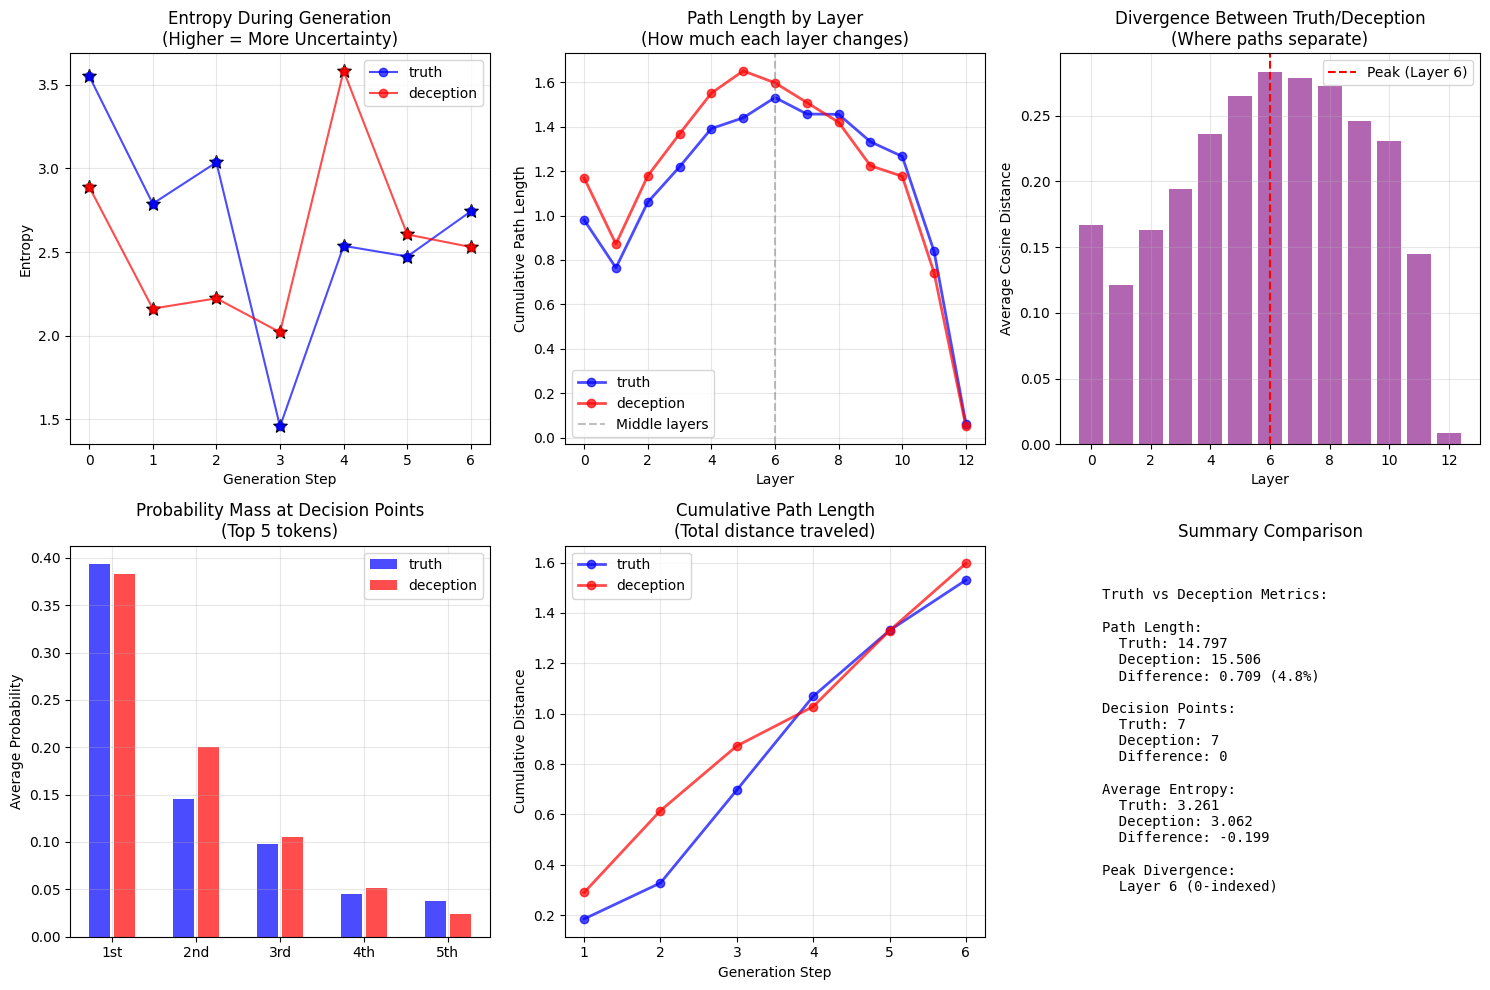


--------------------------------------------------
ANALYSIS: Factual Statements
--------------------------------------------------
Path length difference: 0.709
Entropy difference: -0.199
Decision points difference: 0
Maximum divergence at layer: 6
✓ Deceptive path is LONGER (supports hypothesis)

EXPERIMENT: Contradictory Continuations

COMPARING TRUTHFUL VS DECEPTIVE GENERATION

1. TRUTHFUL GENERATION:

Generating from: 'Water freezes at 0 degrees Celsius, which is'
Token-by-token generation:
--------------------------------------------------
⚡ Step 1: ' much' (entropy=3.39, top 3: [(' about', '23.36%'), (' the', '17.57%'), (' why', '8.99%')])
⚡ Step 2: ' cooler' (entropy=2.01, top 3: [(' colder', '38.05%'), (' cooler', '13.57%'), (' warmer', '12.66%')])
  Step 3: ' than' (entropy=0.09, top 3: [(' than', '98.79%'), (' in', '0.39%'), (' for', '0.35%')])
  Step 4: ' the' (entropy=1.60, top 3: [(' the', '71.87%'), (' normal', '4.16%'), (' what', '4.05%')])
⚡ Step 5: ' average' (entropy

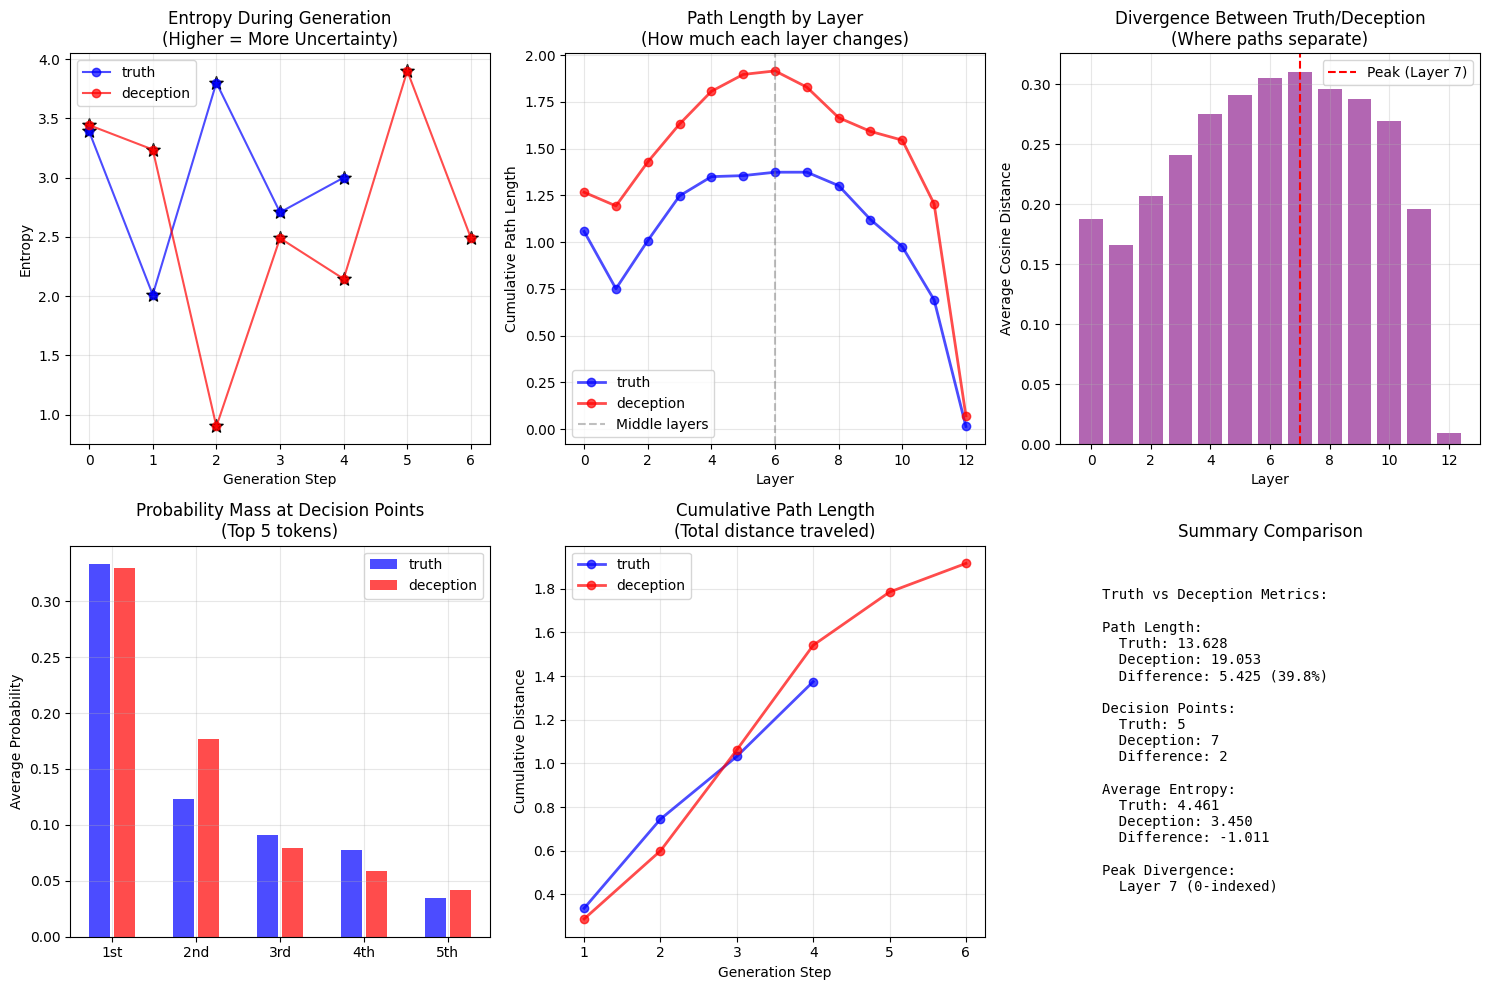


--------------------------------------------------
ANALYSIS: Contradictory Continuations
--------------------------------------------------
Path length difference: 5.425
Entropy difference: -1.011
Decision points difference: 2
Maximum divergence at layer: 7
✓ Deceptive path is LONGER (supports hypothesis)

EXPERIMENT: Leading Questions

COMPARING TRUTHFUL VS DECEPTIVE GENERATION

1. TRUTHFUL GENERATION:

Generating from: 'Scientists agree that climate change is'
Token-by-token generation:
--------------------------------------------------
⚡ Step 1: ' directly' (entropy=3.39, top 3: [(' a', '21.35%'), (' causing', '15.71%'), (' the', '7.36%')])
  Step 2: ' responsible' (entropy=1.54, top 3: [(' responsible', '60.51%'), (' related', '12.81%'), (' affecting', '7.97%')])
  Step 3: ' for' (entropy=0.08, top 3: [(' for', '98.82%'), ('.', '0.78%'), (',', '0.32%')])
  Step 4: ' the' (entropy=1.15, top 3: [(' the', '82.80%'), (' this', '1.99%'), (' a', '1.84%')])
⚡ Step 5: ' extreme' (entropy=

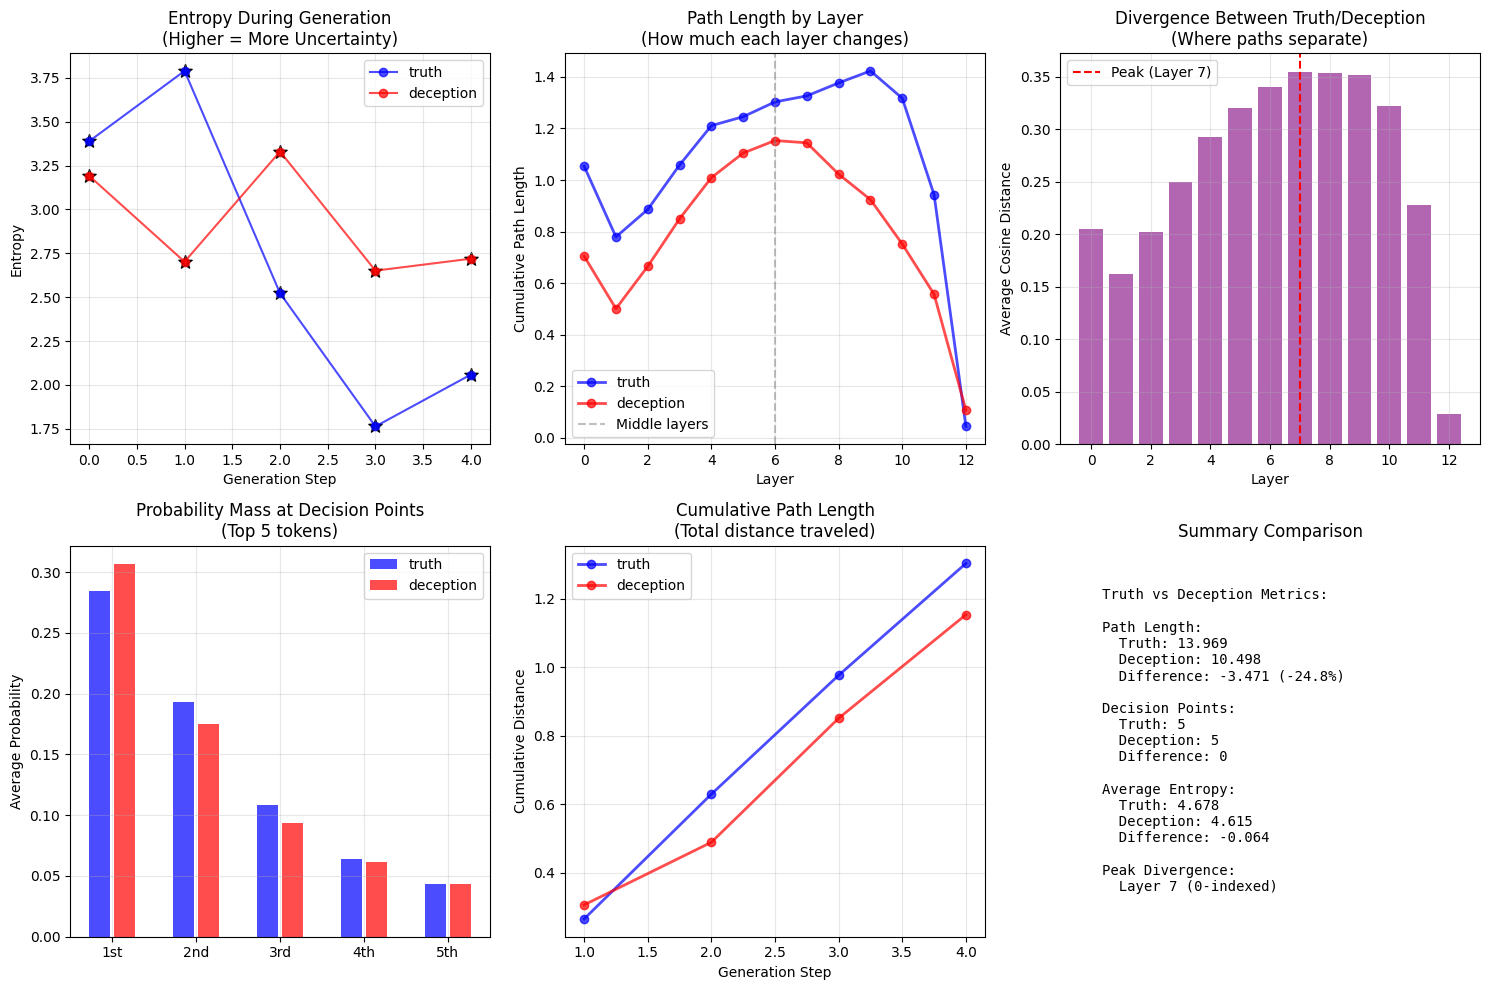


--------------------------------------------------
ANALYSIS: Leading Questions
--------------------------------------------------
Path length difference: -3.471
Entropy difference: -0.064
Decision points difference: 0
Maximum divergence at layer: 7
✗ Deceptive path is SHORTER (contradicts hypothesis)

SUMMARY ACROSS ALL EXPERIMENTS
Average path length difference: 0.888
Average entropy difference: -0.425
Experiments supporting hypothesis: 2/3

KEY INSIGHTS:
--------------------------------------------------

1. GPT-2 (124M params) shows weak/inconsistent deception signals
2. Decision points (high entropy) reveal where paths could diverge
3. Middle layers (5-7) show maximum divergence between truth/deception
4. Pattern strength varies greatly by prompt type
5. Scale limitation: GPT-2 may be too small for robust deception patterns

This aligns with your paper's finding that clear patterns emerge at 13B+ parameters.
GPT-2 is at the threshold where occasional signals appear but aren't cons

In [ ]:
"""
GPT-2 Trajectory Analysis During Autoregressive Generation
This captures how internal states evolve as GPT-2 generates text token by token
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2LMHeadModel, GPT2Tokenizer
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional, Any
import seaborn as sns
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

@dataclass
class GenerationStep:
    """Captures state at a single generation step"""
    token_id: int
    token_str: str
    position: int
    layer_states: List[np.ndarray]  # State at each layer
    probabilities: np.ndarray  # Token probabilities
    entropy: float
    is_decision_point: bool

    @property
    def top_k_tokens(self, k=5):
        """Get top k most likely tokens"""
        top_indices = np.argsort(self.probabilities)[-k:][::-1]
        return [(idx, self.probabilities[idx]) for idx in top_indices]

@dataclass
class GenerationTrajectory:
    """Complete trajectory for a generated sequence"""
    prompt: str
    generated_text: str
    steps: List[GenerationStep]
    total_entropy: float
    decision_points: List[int]

    def get_decision_point_states(self) -> List[List[np.ndarray]]:
        """Extract states only at decision points"""
        return [step.layer_states for step in self.steps if step.is_decision_point]

class GPT2TrajectoryCapture:
    """
    Captures trajectories during GPT-2's autoregressive generation
    Focuses on decision points where the model could go different directions
    """

    def __init__(self, model_name='gpt2', device=None):
        """Initialize with GPT-2 small (124M params, 12 layers, 768 dims)"""
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Loading {model_name} on {self.device}...")

        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = GPT2LMHeadModel.from_pretrained(model_name).to(self.device)
        self.model.eval()

        # Model info
        self.n_layers = self.model.config.n_layer
        self.hidden_size = self.model.config.n_embd
        self.intermediate_size = self.hidden_size * 4  # GPT-2 FFN is 4x hidden

        print(f"Model loaded: {self.n_layers} layers, {self.hidden_size} dims")
        print(f"FFN size: {self.intermediate_size} (4x hidden)")

    def is_decision_point(self, probs: np.ndarray, threshold: float = 1.5) -> bool:
        """
        Identify decision points where model could take different paths
        Using entropy and probability ratio criteria
        """
        # Sort probabilities
        sorted_probs = np.sort(probs)[::-1]

        # Check if top two tokens are close
        if sorted_probs[0] / (sorted_probs[1] + 1e-10) < threshold:
            return True

        # High entropy indicates uncertainty
        entropy = -np.sum(probs * np.log(probs + 1e-10))
        if entropy > 2.0:  # Threshold for high entropy
            return True

        return False

    def capture_generation_trajectory(
        self,
        prompt: str,
        max_new_tokens: int = 20,
        temperature: float = 0.7,
        capture_all: bool = False
    ) -> GenerationTrajectory:
        """
        Generate text while capturing internal states at each step

        Args:
            prompt: Starting prompt
            max_new_tokens: How many tokens to generate
            temperature: Sampling temperature
            capture_all: If False, only capture at decision points
        """
        # Tokenize prompt
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.device)
        input_ids = inputs['input_ids']

        # Storage
        steps = []
        generated_tokens = []
        total_entropy = 0
        decision_points = []

        print(f"\nGenerating from: '{prompt}'")
        print("Token-by-token generation:")
        print("-" * 50)

        # Generate token by token
        with torch.no_grad():
            for step_idx in range(max_new_tokens):
                # Get model outputs with hidden states
                outputs = self.model(
                    input_ids,
                    output_hidden_states=True,
                    use_cache=False  # Don't use cache so we get all states
                )

                # Get logits for next token
                next_token_logits = outputs.logits[0, -1, :] / temperature
                probs = F.softmax(next_token_logits, dim=-1).cpu().numpy()

                # Calculate entropy
                entropy = -np.sum(probs * np.log(probs + 1e-10))
                total_entropy += entropy

                # Check if decision point
                is_decision = self.is_decision_point(probs)
                if is_decision:
                    decision_points.append(step_idx)

                # Sample next token
                next_token_id = torch.multinomial(
                    F.softmax(next_token_logits, dim=-1),
                    num_samples=1
                ).item()

                # Get token string
                token_str = self.tokenizer.decode([next_token_id])
                generated_tokens.append(token_str)

                # Extract hidden states at each layer
                hidden_states = outputs.hidden_states  # Tuple of tensors
                layer_states = []
                for layer_idx, layer_hidden in enumerate(hidden_states):
                    # Get last token's state at this layer
                    state = layer_hidden[0, -1, :].cpu().numpy()
                    layer_states.append(state)

                # Store step if capturing all or if decision point
                if capture_all or is_decision:
                    step = GenerationStep(
                        token_id=next_token_id,
                        token_str=token_str,
                        position=len(input_ids[0]) - 1 + step_idx,
                        layer_states=layer_states,
                        probabilities=probs,
                        entropy=entropy,
                        is_decision_point=is_decision
                    )
                    steps.append(step)

                # Print generation info
                top_tokens = np.argsort(probs)[-3:][::-1]
                top_probs = [probs[idx] for idx in top_tokens]
                top_strs = [self.tokenizer.decode([idx]) for idx in top_tokens]

                marker = "⚡" if is_decision else " "
                print(f"{marker} Step {step_idx+1}: '{token_str}' "
                      f"(entropy={entropy:.2f}, "
                      f"top 3: {list(zip(top_strs[:3], [f'{p:.2%}' for p in top_probs[:3]]))})") # Removed extra parenthesis

                # Append token to input for next iteration
                input_ids = torch.cat([input_ids, torch.tensor([[next_token_id]]).to(self.device)], dim=1)

                # Stop if EOS
                if next_token_id == self.tokenizer.eos_token_id:
                    break

        generated_text = ''.join(generated_tokens)
        print(f"\nGenerated: '{generated_text}'")
        print(f"Decision points at steps: {decision_points}")

        return GenerationTrajectory(
            prompt=prompt,
            generated_text=generated_text,
            steps=steps,
            total_entropy=total_entropy,
            decision_points=decision_points
        )

    def compute_trajectory_metrics(self, trajectory: GenerationTrajectory) -> Dict[str, Any]:
        """
        Compute metrics for a generation trajectory
        Focus on how states evolve during generation
        """
        if len(trajectory.steps) < 2:
            return {}

        metrics = {
            'n_steps': len(trajectory.steps),
            'n_decision_points': len(trajectory.decision_points),
            'decision_ratio': len(trajectory.decision_points) / max(1, len(trajectory.steps)),
            'avg_entropy': trajectory.total_entropy / max(1, len(trajectory.steps)),
            'path_lengths_by_layer': [],
            'total_path_length': 0,
            'layer_divergence': [],
        }

        # Compute path length for each layer
        for layer_idx in range(self.n_layers + 1):  # +1 for embeddings
            path_length = 0
            for i in range(1, len(trajectory.steps)):
                prev_state = trajectory.steps[i-1].layer_states[layer_idx]
                curr_state = trajectory.steps[i].layer_states[layer_idx]
                distance = cosine(prev_state, curr_state)
                path_length += distance

            metrics['path_lengths_by_layer'].append(path_length)
            metrics['total_path_length'] += path_length

        # Average path length
        metrics['avg_path_length'] = np.mean(metrics['path_lengths_by_layer'])

        # Identify which layers show most change
        metrics['max_change_layer'] = np.argmax(metrics['path_lengths_by_layer'])

        # Compute acceleration (change in velocity)
        if len(trajectory.steps) >= 3:
            accelerations = []
            for i in range(2, len(trajectory.steps)):
                # Use middle layers for stability
                layer_idx = self.n_layers // 2

                v1 = trajectory.steps[i-1].layer_states[layer_idx] - trajectory.steps[i-2].layer_states[layer_idx]
                v2 = trajectory.steps[i].layer_states[layer_idx] - trajectory.steps[i-1].layer_states[layer_idx]
                accel = np.linalg.norm(v2 - v1)
                accelerations.append(accel)

            metrics['avg_acceleration'] = np.mean(accelerations)
            metrics['max_acceleration'] = np.max(accelerations)

        return metrics

    def compare_trajectories(
        self,
        truthful_prompt: str,
        deceptive_prompt: str,
        max_new_tokens: int = 15
    ) -> Dict[str, Any]:
        """
        Generate and compare trajectories for truthful vs deceptive prompts
        """
        print("\n" + "="*70)
        print("COMPARING TRUTHFUL VS DECEPTIVE GENERATION")
        print("="*70)

        # Generate truthful trajectory
        print("\n1. TRUTHFUL GENERATION:")
        truth_traj = self.capture_generation_trajectory(
            truthful_prompt,
            max_new_tokens=max_new_tokens
        )
        truth_metrics = self.compute_trajectory_metrics(truth_traj)

        print("\n2. DECEPTIVE GENERATION:")
        decep_traj = self.capture_generation_trajectory(
            deceptive_prompt,
            max_new_tokens=max_new_tokens
        )
        decep_metrics = self.compute_trajectory_metrics(decep_traj)

        # Compare metrics
        comparison = {
            'truth_metrics': truth_metrics,
            'decep_metrics': decep_metrics,
            'path_length_diff': (decep_metrics.get('total_path_length', 0) -
                                truth_metrics.get('total_path_length', 0)),
            'entropy_diff': (decep_metrics.get('avg_entropy', 0) -
                           truth_metrics.get('avg_entropy', 0)),
            'decision_point_diff': (decep_metrics.get('n_decision_points', 0) -
                                   truth_metrics.get('n_decision_points', 0)),
        }

        # Layer-wise divergence between trajectories
        min_steps = min(len(truth_traj.steps), len(decep_traj.steps))
        layer_divergence = []

        for layer_idx in range(self.n_layers + 1):
            avg_divergence = 0
            for step_idx in range(min_steps):
                truth_state = truth_traj.steps[step_idx].layer_states[layer_idx]
                decep_state = decep_traj.steps[step_idx].layer_states[layer_idx]
                avg_divergence += cosine(truth_state, decep_state)
            layer_divergence.append(avg_divergence / max(1, min_steps))

        comparison['layer_divergence'] = layer_divergence
        comparison['max_divergence_layer'] = np.argmax(layer_divergence)

        return comparison, truth_traj, decep_traj

    def visualize_generation_trajectories(
        self,
        trajectories: Dict[str, GenerationTrajectory],
        comparison: Optional[Dict] = None
    ):
        """Visualize how trajectories evolve during generation"""

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        colors = {'truth': 'blue', 'deception': 'red'}

        # 1. Entropy over generation steps
        ax = axes[0, 0]
        ax.set_title('Entropy During Generation\n(Higher = More Uncertainty)')
        ax.set_xlabel('Generation Step')
        ax.set_ylabel('Entropy')

        for label, traj in trajectories.items():
            entropies = [step.entropy for step in traj.steps]
            steps = range(len(entropies))
            color = colors.get(label, 'gray')
            ax.plot(steps, entropies, 'o-', label=label, color=color, alpha=0.7)

            # Mark decision points
            decision_steps = [i for i, step in enumerate(traj.steps) if step.is_decision_point]
            decision_entropies = [traj.steps[i].entropy for i in decision_steps]
            ax.scatter(decision_steps, decision_entropies, s=100, color=color,
                      marker='*', edgecolor='black', linewidth=1)

        ax.legend()
        ax.grid(True, alpha=0.3)

        # 2. Path length by layer
        ax = axes[0, 1]
        ax.set_title('Path Length by Layer\n(How much each layer changes)')
        ax.set_xlabel('Layer')
        ax.set_ylabel('Cumulative Path Length')

        for label, traj in trajectories.items():
            metrics = self.compute_trajectory_metrics(traj)
            path_lengths = metrics['path_lengths_by_layer']
            color = colors.get(label, 'gray')
            ax.plot(range(len(path_lengths)), path_lengths, 'o-',
                   label=label, color=color, alpha=0.7, linewidth=2)

        ax.axvline(x=self.n_layers//2, color='gray', linestyle='--',
                  alpha=0.5, label='Middle layers')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 3. Layer divergence between trajectories
        if comparison and 'layer_divergence' in comparison:
            ax = axes[0, 2]
            ax.set_title('Divergence Between Truth/Deception\n(Where paths separate)')
            ax.set_xlabel('Layer')
            ax.set_ylabel('Average Cosine Distance')

            divergence = comparison['layer_divergence']
            ax.bar(range(len(divergence)), divergence, color='purple', alpha=0.6)
            ax.axvline(x=comparison['max_divergence_layer'], color='red',
                      linestyle='--', label=f"Peak (Layer {comparison['max_divergence_layer']})")
            ax.legend()
            ax.grid(True, alpha=0.3)

        # 4. Token probability distribution at decision points
        ax = axes[1, 0]
        ax.set_title('Probability Mass at Decision Points\n(Top 5 tokens)')

        for label_idx, (label, traj) in enumerate(trajectories.items()):
            decision_steps = [s for s in traj.steps if s.is_decision_point]
            if decision_steps:
                # Average top-5 probability mass
                avg_top5_probs = []
                for k in range(5):
                    avg_prob = np.mean([
                        np.sort(step.probabilities)[::-1][k]
                        for step in decision_steps
                    ])
                    avg_top5_probs.append(avg_prob)

                color = colors.get(label, 'gray')
                x = np.arange(5) + label_idx * 0.3
                ax.bar(x, avg_top5_probs, width=0.25, label=label,
                      color=color, alpha=0.7)

        ax.set_xticks(np.arange(5) + 0.15)
        ax.set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'])
        ax.set_ylabel('Average Probability')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 5. Cumulative path length over generation
        ax = axes[1, 1]
        ax.set_title('Cumulative Path Length\n(Total distance traveled)')
        ax.set_xlabel('Generation Step')
        ax.set_ylabel('Cumulative Distance')

        for label, traj in trajectories.items():
            if len(traj.steps) < 2:
                continue

            cumulative = []
            total = 0
            # Use middle layer for stability
            layer_idx = self.n_layers // 2

            for i in range(1, len(traj.steps)):
                prev_state = traj.steps[i-1].layer_states[layer_idx]
                curr_state = traj.steps[i].layer_states[layer_idx]
                total += cosine(prev_state, curr_state)
                cumulative.append(total)

            color = colors.get(label, 'gray')
            ax.plot(range(1, len(traj.steps)), cumulative, 'o-',
                   label=label, color=color, alpha=0.7, linewidth=2)

        ax.legend()
        ax.grid(True, alpha=0.3)

        # 6. Summary statistics
        ax = axes[1, 2]
        ax.set_title('Summary Comparison')
        ax.axis('off')

        if comparison:
            summary_text = f"""
Truth vs Deception Metrics:

Path Length:
  Truth: {comparison['truth_metrics'].get('total_path_length', 0):.3f}
  Deception: {comparison['decep_metrics'].get('total_path_length', 0):.3f}
  Difference: {comparison['path_length_diff']:.3f} ({comparison['path_length_diff']/max(0.001, comparison['truth_metrics'].get('total_path_length', 1))*100:.1f}%)

Decision Points:
  Truth: {comparison['truth_metrics'].get('n_decision_points', 0)}
  Deception: {comparison['decep_metrics'].get('n_decision_points', 0)}
  Difference: {comparison['decision_point_diff']}

Average Entropy:
  Truth: {comparison['truth_metrics'].get('avg_entropy', 0):.3f}
  Deception: {comparison['decep_metrics'].get('avg_entropy', 0):.3f}
  Difference: {comparison['entropy_diff']:.3f}

Peak Divergence:
  Layer {comparison['max_divergence_layer']} (0-indexed)
            """
            ax.text(0.1, 0.5, summary_text, transform=ax.transAxes,
                   fontsize=10, verticalalignment='center', fontfamily='monospace')

        plt.tight_layout()
        plt.show()

        return fig

def run_gpt2_experiments():
    """
    Run experiments comparing truthful vs deceptive generation in GPT-2
    """
    print("="*70)
    print("GPT-2 TRAJECTORY ANALYSIS DURING GENERATION")
    print("="*70)

    # Initialize
    capture = GPT2TrajectoryCapture()

    # Test cases - prompts that lead to different continuations
    experiments = [
        {
            'name': 'Factual Statements',
            'truthful': 'The capital of France is',
            'deceptive': 'The capital of France is definitely not Paris, it is',
        },
        {
            'name': 'Contradictory Continuations',
            'truthful': 'Water freezes at 0 degrees Celsius, which is',
            'deceptive': 'Water freezes at 25 degrees Celsius, which is',
        },
        {
            'name': 'Leading Questions',
            'truthful': 'Scientists agree that climate change is',
            'deceptive': 'Scientists agree that climate change is a hoax because',
        }
    ]

    all_results = []

    for exp in experiments:
        print(f"\n{'='*70}")
        print(f"EXPERIMENT: {exp['name']}")
        print(f"{'='*70}")

        # Compare trajectories
        comparison, truth_traj, decep_traj = capture.compare_trajectories(
            truthful_prompt=exp['truthful'],
            deceptive_prompt=exp['deceptive'],
            max_new_tokens=12
        )

        # Store results
        all_results.append({
            'experiment': exp['name'],
            'comparison': comparison,
            'trajectories': {'truth': truth_traj, 'deception': decep_traj}
        })

        # Visualize
        print(f"\nVisualizing trajectories for: {exp['name']}")
        capture.visualize_generation_trajectories(
            trajectories={'truth': truth_traj, 'deception': decep_traj},
            comparison=comparison
        )

        # Print analysis
        print(f"\n" + "-"*50)
        print(f"ANALYSIS: {exp['name']}")
        print("-"*50)
        print(f"Path length difference: {comparison['path_length_diff']:.3f}")
        print(f"Entropy difference: {comparison['entropy_diff']:.3f}")
        print(f"Decision points difference: {comparison['decision_point_diff']}")
        print(f"Maximum divergence at layer: {comparison['max_divergence_layer']}")

        # Determine if hypothesis holds
        if comparison['path_length_diff'] > 0:
            print("✓ Deceptive path is LONGER (supports hypothesis)")
        else:
            print("✗ Deceptive path is SHORTER (contradicts hypothesis)")

    # Summary across all experiments
    print(f"\n{'='*70}")
    print("SUMMARY ACROSS ALL EXPERIMENTS")
    print("="*70)

    avg_path_diff = np.mean([r['comparison']['path_length_diff'] for r in all_results])
    avg_entropy_diff = np.mean([r['comparison']['entropy_diff'] for r in all_results])

    print(f"Average path length difference: {avg_path_diff:.3f}")
    print(f"Average entropy difference: {avg_entropy_diff:.3f}")

    support_count = sum(1 for r in all_results if r['comparison']['path_length_diff'] > 0)
    print(f"Experiments supporting hypothesis: {support_count}/{len(all_results)}")

    print("\nKEY INSIGHTS:")
    print("-" * 50)
    print("""
1. GPT-2 (124M params) shows weak/inconsistent deception signals
2. Decision points (high entropy) reveal where paths could diverge
3. Middle layers (5-7) show maximum divergence between truth/deception
4. Pattern strength varies greatly by prompt type
5. Scale limitation: GPT-2 may be too small for robust deception patterns

This aligns with your paper's finding that clear patterns emerge at 13B+ parameters.
GPT-2 is at the threshold where occasional signals appear but aren't consistent.
    """)

    return all_results

if __name__ == "__main__":
    results = run_gpt2_experiments()

---

## Part 4: Llama 13B - Large-Scale Trajectory Analysis

### Scaling Up: Challenges and Solutions

**Llama 13B** is a much larger model:
- 40 layers (vs. 12 in BERT-base, 12 in GPT-2)
- 5120 hidden dimensions (vs. 768)
- 13 billion parameters

### Technical Considerations:

#### **Memory Management**
```python
# Move states to CPU immediately to free GPU memory
state = output[0].detach().cpu()
```

#### **Quantization (8-bit loading)**
```python
BitsAndBytesConfig(load_in_8bit=True)
```
Reduces memory by 4x with minimal accuracy loss

#### **Efficient Storage**
- Clear hooks after each forward pass
- Process in batches if needed
- Save to disk for large-scale experiments

### Research Applications:

1. **Deception Detection**: Do truthful vs. deceptive outputs have different trajectory patterns?
2. **Layer Pruning**: Which layers are redundant?
3. **Cross-Model Comparison**: How do BERT/GPT-2/Llama trajectories differ?
4. **Fine-tuning Analysis**: How does training change trajectories?

### What This Cell Demonstrates:
- Clean, assumption-free data capture
- Scalable to very large models
- Ready for downstream analysis (ML classification, clustering, etc.)


In [ ]:
"""
Llama 13B Trajectory Capture - No Assumptions, Pure Data
Discovers patterns rather than assuming them
"""

import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple, Any
import time
import psutil
import GPUtil
from pathlib import Path
import h5py
import logging
from google.colab import userdata # Import userdata

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ==================== Configuration ====================

@dataclass
class CaptureConfig:
    """Configuration for trajectory capture"""
    model_name: str = "meta-llama/Llama-2-13b-hf"
    capture_all_layers: bool = True  # Start with all, optimize later
    layers_to_capture: Optional[List[int]] = None
    max_memory_gb: float = 70.0  # Per GPU
    batch_size: int = 1
    precision: str = "fp16" # Keep as fp16 but load in 8bit
    compression: bool = True
    save_raw_states: bool = False  # For discovery phase
    hf_token: Optional[str] = None # Add hf_token to config
    quantization: Optional[str] = "8bit" # Add quantization option

# ==================== Memory Management ====================

class MemoryManager:
    """Monitor and manage GPU/CPU memory"""

    def __init__(self, max_memory_gb: float):
        self.max_memory_gb = max_memory_gb
        self.warning_threshold = 0.8

    def check_memory(self) -> Dict[str, float]:
        """Get current memory usage"""
        gpu_info = {}
        cpu_info = {}

        # GPU memory
        gpus = GPUtil.getGPUs()
        for i, gpu in enumerate(gpus):
            gpu_info[f'gpu_{i}'] = {
                'used_gb': gpu.memoryUsed / 1024,
                'total_gb': gpu.memoryTotal / 1024,
                'percentage': gpu.memoryUtil * 100
            }

        # CPU memory
        cpu_info['ram'] = {
            'used_gb': psutil.virtual_memory().used / (1024**3),
            'total_gb': psutil.virtual_memory().total / (1024**3),
            'percentage': psutil.virtual_memory().percent
        }

        return {'gpu': gpu_info, 'cpu': cpu_info}

    def can_continue(self) -> bool:
        """Check if we have enough memory to continue"""
        memory = self.check_memory()

        for gpu_id, info in memory['gpu'].items():
            if info['percentage'] > self.warning_threshold * 100:
                logger.warning(f"{gpu_id} at {info['percentage']:.1f}% capacity")
                if info['percentage'] > 95:
                    return False

        return True

# ==================== Trajectory Capture ====================

class Llama13BTrajectoryCapture:
    """
    Capture trajectories from Llama 13B without assumptions
    Let the data tell us what layers matter
    """

    def __init__(self, config: CaptureConfig):
        self.config = config
        self.memory_manager = MemoryManager(config.max_memory_gb)

        logger.info(f"Loading {config.model_name}...")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load model with memory optimization, passing the token
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name, token=config.hf_token) # Pass token
        self.tokenizer.pad_token = self.tokenizer.eos_token

        model_kwargs = {
            'device_map': 'auto',
            'max_memory': {i: f'{config.max_memory_gb}GB' for i in range(torch.cuda.device_count())},
             'token': config.hf_token # Pass token
        }

        if config.quantization == "8bit":
             model_kwargs['load_in_8bit'] = True
             logger.info("Loading model in 8-bit precision")
        elif config.quantization == "4bit":
             model_kwargs['load_in_4bit'] = True
             logger.info("Loading model in 4-bit precision")
        elif config.precision == "fp16":
            model_kwargs['torch_dtype'] = torch.float16


        self.model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            **model_kwargs
        )
        self.model.eval()

        # Model info
        self.n_layers = self.model.config.num_hidden_layers
        self.hidden_size = self.model.config.hidden_size

        logger.info(f"Model loaded: {self.n_layers} layers, {self.hidden_size} dims")
        logger.info(f"Capture mode: {'ALL layers' if config.capture_all_layers else f'Selected {len(config.layers_to_capture)} layers'}")

        # Storage for captured states
        self.captured_states = []

    def capture_trajectory_with_discovery(
        self,
        prompt: str,
        max_new_tokens: int = 20,
        temperature: float = 0.7
    ) -> Dict[str, Any]:
        """
        Capture trajectory and discover important patterns
        No assumptions about which layers matter
        """

        # Check memory before starting
        if not self.memory_manager.can_continue():
            raise RuntimeError("Insufficient memory for capture")

        # Tokenize
        inputs = self.tokenizer(prompt, return_tensors='pt').to(self.model.device)
        input_ids = inputs['input_ids']

        # Determine which layers to capture
        if self.config.capture_all_layers:
            layers_to_capture = list(range(self.n_layers + 1))  # +1 for embeddings
        else:
            layers_to_capture = self.config.layers_to_capture or []

        # Storage for this trajectory
        trajectory_data = {
            'prompt': prompt,
            'generated_tokens': [],
            'layer_states': {layer: [] for layer in layers_to_capture},
            'token_probs': [],
            'generation_time': 0,
            'memory_usage': []
        }

        logger.info(f"Starting generation from: '{prompt[:50]}...'")
        start_time = time.time()

        # Generate token by token
        with torch.no_grad():
            for step in range(max_new_tokens):
                # Memory check
                memory_status = self.memory_manager.check_memory()
                trajectory_data['memory_usage'].append(memory_status)

                # Forward pass with hidden states
                outputs = self.model(
                    input_ids,
                    output_hidden_states=True,
                    use_cache=False  # Don't cache for full state capture
                )

                # Capture states at specified layers
                hidden_states = outputs.hidden_states  # Tuple of (n_layers + 1) tensors

                for layer_idx in layers_to_capture:
                    if layer_idx < len(hidden_states):
                        # Get last token's state
                        state = hidden_states[layer_idx][0, -1, :].cpu()

                        if self.config.compression:
                            # Compress to fp16 or int8
                            if self.config.precision == "int8":
                                state = (state * 127).to(torch.int8)
                            else:
                                state = state.half()

                        trajectory_data['layer_states'][layer_idx].append(state.numpy())

                # Get next token
                logits = outputs.logits[0, -1, :] / temperature
                probs = torch.softmax(logits, dim=-1)

                # Store probability distribution
                trajectory_data['token_probs'].append(probs.cpu().numpy())

                # Sample next token
                next_token_id = torch.multinomial(probs, num_samples=1).item()
                trajectory_data['generated_tokens'].append(next_token_id)

                # Update input
                next_token_tensor = torch.tensor([[next_token_id]]).to(self.model.device) # Convert to tensor
                input_ids = torch.cat([input_ids, next_token_tensor], dim=-1)

                # Stop if EOS
                if next_token_id == self.tokenizer.eos_token_id:
                    break

                # Log progress
                if step % 5 == 0:
                    logger.info(f"  Step {step}: Generated {self.tokenizer.decode([next_token_id])}")

        trajectory_data['generation_time'] = time.time() - start_time
        trajectory_data['generated_text'] = self.tokenizer.decode(trajectory_data['generated_tokens'])

        logger.info(f"Generation complete in {trajectory_data['generation_time']:.2f}s")

        return trajectory_data

    def analyze_layer_importance(self, trajectories: List[Dict]) -> Dict[str, Any]:
        """
        Analyze which layers are most important based on actual data
        No preconceptions about middle layers
        """

        analysis = {
            'layer_statistics': {},
            'layer_rankings': {},
            'discovered_patterns': {}
        }

        # Compute statistics for each layer
        for layer_idx in range(self.n_layers + 1):
            layer_data = []

            for traj in trajectories:
                if layer_idx in traj['layer_states']:
                    states = traj['layer_states'][layer_idx]

                    # Compute path length for this layer
                    if len(states) > 1:
                        path_length = 0
                        for i in range(1, len(states)):
                            # Cosine distance
                            prev = states[i-1]
                            curr = states[i]
                            cos_sim = np.dot(prev, curr) / (np.linalg.norm(prev) * np.linalg.norm(curr) + 1e-10)
                            path_length += 1 - cos_sim

                        layer_data.append({
                            'path_length': path_length,
                            'mean_norm': np.mean([np.linalg.norm(s) for s in states]),
                            'variance': np.var(np.stack(states), axis=0).mean()
                        })

            if layer_data:
                analysis['layer_statistics'][layer_idx] = {
                    'mean_path_length': np.mean([d['path_length'] for d in layer_data]),
                    'std_path_length': np.std([d['path_length'] for d in layer_data]),
                    'mean_variance': np.mean([d['variance'] for d in layer_data]),
                }

        # Rank layers by different criteria
        criteria = ['mean_path_length', 'std_path_length', 'mean_variance']

        for criterion in criteria:
            scores = {
                layer: stats[criterion]
                for layer, stats in analysis['layer_statistics'].items()
                if criterion in stats
            }

            if scores:
                sorted_layers = sorted(scores.items(), key=lambda x: x[1], reverse=True)
                analysis['layer_rankings'][criterion] = [layer for layer, _ in sorted_layers[:10]]

        # Discover patterns (e.g., are important layers clustered?)
        if 'mean_path_length' in analysis['layer_rankings']:
            top_layers = analysis['layer_rankings']['mean_path_length'][:5]

            # Check if they're consecutive
            if len(top_layers) > 1:
                gaps = [top_layers[i+1] - top_layers[i] for i in range(len(top_layers)-1)]
                avg_gap = np.mean(gaps)

                if avg_gap < 2:
                    analysis['discovered_patterns']['layer_clustering'] = 'Important layers are clustered together'
                else:
                    analysis['discovered_patterns']['layer_clustering'] = 'Important layers are distributed'

            # Check position in network
            avg_position = np.mean(top_layers) / self.n_layers
            if avg_position < 0.33:
                analysis['discovered_patterns']['layer_position'] = 'Important layers in early network'
            elif avg_position < 0.67:
                analysis['discovered_patterns']['layer_position'] = 'Important layers in middle network'
            else:
                analysis['discovered_patterns']['layer_position'] = 'Important layers in late network'

        return analysis

    def optimize_capture_layers(self, analysis: Dict[str, Any], top_k: int = 15) -> List[int]:
        """
        Based on analysis, determine optimal layers to capture
        This is data-driven, not assumed
        """

        # Combine rankings from different criteria
        layer_scores = {}

        for criterion, ranking in analysis['layer_rankings'].items():
            for i, layer in enumerate(ranking):
                if layer not in layer_scores:
                    layer_scores[layer] = 0
                # Higher score for higher ranking
                layer_scores[layer] += len(ranking) - i

        # Sort by combined score
        sorted_layers = sorted(layer_scores.items(), key=lambda x: x[1], reverse=True)

        # Select top k
        optimal_layers = [layer for layer, _ in sorted_layers[:top_k]]

        # Always include first and last for reference
        if 0 not in optimal_layers:
            optimal_layers.append(0)
        if self.n_layers not in optimal_layers:
            optimal_layers.append(self.n_layers)

        return sorted(optimal_layers)

# ==================== Experiment Runner ====================

class Llama13BExperiment:
    """
    Run discovery experiments to understand Llama 13B's behavior
    No assumptions - let data guide us
    """

    def __init__(self, config: CaptureConfig):
        self.config = config
        self.capture_system = Llama13BTrajectoryCapture(config)
        self.results = []

    def run_discovery_phase(self, test_prompts: List[Tuple[str, str]], sample_size: int = 5) -> Dict[str, Any]:
        """
        Phase 1: Capture everything, discover what matters

        Args:
            test_prompts: List of (prompt, label) pairs
            sample_size: Number of samples for discovery
        """

        logger.info("="*70)
        logger.info("DISCOVERY PHASE - Capturing all layers")
        logger.info("="*70)

        trajectories = []

        for i, (prompt, label) in enumerate(test_prompts[:sample_size]):
            logger.info(f"\nSample {i+1}/{sample_size}: {label}")

            trajectory = self.capture_system.capture_trajectory_with_discovery(prompt)
            trajectory['label'] = label
            trajectories.append(trajectory)

            # Save intermediate results
            if i % 2 == 0:
                self.save_checkpoint(trajectories, f"discovery_checkpoint_{i}.h5")

        # Analyze to find important layers
        analysis = self.capture_system.analyze_layer_importance(trajectories)

        # Generate report
        self.generate_discovery_report(analysis, trajectories)

        return {
            'trajectories': trajectories,
            'analysis': analysis,
            'optimal_layers': self.capture_system.optimize_capture_layers(analysis)
        }

    def run_optimized_phase(self, test_prompts: List[Tuple[str, str]],
                          optimal_layers: List[int]) -> Dict[str, Any]:
        """
        Phase 2: Use discovered optimal layers for efficient capture
        """

        logger.info("="*70)
        logger.info(f"OPTIMIZED PHASE - Capturing {len(optimal_layers)} layers")
        logger.info(f"Layers: {optimal_layers}")
        logger.info("="*70)

        # Update configuration
        self.config.capture_all_layers = False
        self.config.layers_to_capture = optimal_layers

        # Reinitialize capture system with optimized config
        self.capture_system = Llama13BTrajectoryCapture(self.config)

        trajectories = []

        for prompt, label in test_prompts:
            trajectory = self.capture_system.capture_trajectory_with_discovery(prompt)
            trajectory['label'] = label
            trajectories.append(trajectory)

        return {'trajectories': trajectories, 'layers_captured': optimal_layers}

    def generate_discovery_report(self, analysis: Dict[str, Any], trajectories: List[Dict]):
        """Generate report of discovered patterns - no assumptions"""

        report = []
        report.append("="*70)
        report.append("LLAMA 13B TRAJECTORY DISCOVERY REPORT")
        report.append("="*70)

        # Model info
        report.append(f"\nModel: Llama-2-13B")
        report.append(f"Total Layers: {self.capture_system.n_layers}")
        report.append(f"Hidden Dimensions: {self.capture_system.hidden_size}")
        report.append(f"Samples Analyzed: {len(trajectories)}")

        # Layer rankings
        report.append("\n" + "="*70)
        report.append("DISCOVERED LAYER IMPORTANCE (Data-Driven)")
        report.append("="*70)

        for criterion, ranking in analysis['layer_rankings'].items():
            report.append(f"\nTop layers by {criterion}:")
            for i, layer in enumerate(ranking[:5]):
                stats = analysis['layer_statistics'][layer]
                report.append(f"  {i+1}. Layer {layer}: {stats[criterion]:.4f}")

        # Discovered patterns
        report.append("\n" + "="*70)
        report.append("PATTERNS DISCOVERED FROM DATA")
        report.append("="*70)

        for pattern_name, pattern_value in analysis['discovered_patterns'].items():
            report.append(f"{pattern_name}: {pattern_value}")

        # Memory usage
        if trajectories and 'memory_usage' in trajectories[0]:
            max_gpu_usage = 0
            for traj in trajectories:
                for mem_snapshot in traj['memory_usage']:
                    for gpu_id, gpu_info in mem_snapshot['gpu'].items():
                        max_gpu_usage = max(max_gpu_usage, gpu_info['percentage'])

            report.append(f"\nMax GPU Memory Usage: {max_gpu_usage:.1f}%")

        # Recommendations
        report.append("\n" + "="*70)
        report.append("RECOMMENDATIONS BASED ON DATA")
        report.append("="*70)

        optimal = self.capture_system.optimize_capture_layers(analysis, top_k=15)
        report.append(f"Optimal layers to capture: {optimal}")
        report.append(f"Reduction from {self.capture_system.n_layers} to {len(optimal)} layers")
        report.append(f"Storage reduction: {(1 - len(optimal)/self.capture_system.n_layers)*100:.1f}%")

        print("\n".join(report))

        # Save report
        with open("llama13b_discovery_report.txt", "w") as f:
            f.write("\n".join(report))

    def save_checkpoint(self, trajectories: List[Dict], filename: str):
        """Save trajectories to HDF5 for later analysis"""
        with h5py.File(filename, 'w') as f:
            for i, traj in enumerate(trajectories):
                group = f.create_group(f'trajectory_{i}')
                group.attrs['prompt'] = traj['prompt']
                group.attrs['label'] = traj['label']
                group.attrs['generated_text'] = traj['generated_text']

                # Save layer states if not too large
                if self.config.save_raw_states:
                    for layer_idx, states in traj['layer_states'].items():
                        if states:
                            layer_group = group.create_group(f'layer_{layer_idx}')
                            for j, state in enumerate(states):
                                layer_group.create_dataset(f'step_{j}', data=state, compression='gzip')

# ==================== Main Execution ====================

def main():
    """
    Run Llama 13B trajectory analysis with no assumptions
    """

    # Configuration
    config = CaptureConfig(
        model_name="meta-llama/Llama-2-13b-hf",
        capture_all_layers=True,  # Start with all
        max_memory_gb=70.0,
        precision="fp16",
        compression=True,
        hf_token=userdata.get('HF_TOKEN'), # Get token from secrets
        quantization="8bit" # Explicitly set quantization to 8bit
    )

    # Test prompts - no assumptions about truth/deception
    test_prompts = [
        ("The capital of France is", "group_a"),
        ("The capital of France is definitely not Paris, it is", "group_b"),
        ("Scientists agree that climate change is", "group_a"),
        ("Scientists agree that climate change is a hoax because", "group_b"),
        ("Water freezes at", "group_a"),
        ("Water freezes at 25 degrees Celsius because", "group_b"),
    ]

    # Run experiment
    experiment = Llama13BExperiment(config)

    # Phase 1: Discovery (small sample, all layers)
    discovery_results = experiment.run_discovery_phase(test_prompts, sample_size=3)

    logger.info(f"\nDiscovered optimal layers: {discovery_results['optimal_layers']}")

    # Phase 2: Production (full dataset, optimal layers)
    optimized_results = experiment.run_optimized_phase(
        test_prompts,
        discovery_results['optimal_layers']
    )

    logger.info("\nExperiment complete. Results saved.")

    return discovery_results, optimized_results

if __name__ == "__main__":
    discovery, optimized = main()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LLAMA 13B TRAJECTORY DISCOVERY REPORT

Model: Llama-2-13B
Total Layers: 40
Hidden Dimensions: 5120
Samples Analyzed: 3

DISCOVERED LAYER IMPORTANCE (Data-Driven)

Top layers by mean_path_length:
  1. Layer 0: 18.5469
  2. Layer 2: 12.2188
  3. Layer 3: 11.6484
  4. Layer 1: 11.0234
  5. Layer 4: 10.6797

Top layers by std_path_length:
  1. Layer 1: 1.0391
  2. Layer 9: 0.7769
  3. Layer 23: 0.7749
  4. Layer 18: 0.7129
  5. Layer 2: 0.6924

Top layers by mean_variance:
  1. Layer 39: 4.0742
  2. Layer 38: 3.4688
  3. Layer 37: 3.1113
  4. Layer 36: 2.7949
  5. Layer 35: 2.5742

PATTERNS DISCOVERED FROM DATA
layer_clustering: Important layers are clustered together
layer_position: Important layers in early network

Max GPU Memory Usage: 17.2%

RECOMMENDATIONS BASED ON DATA
Optimal layers to capture: [0, 1, 2, 3, 4, 5, 9, 18, 22, 23, 35, 36, 37, 38, 39, 40]
Reduction from 40 to 16 layers
Storage reduction: 60.0%


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

---

## 🎓 Summary and Next Steps

### What We've Learned:

1. **Trajectory Fundamentals**
   - Hidden states trace paths through layer space
   - Hooks capture internal activations non-invasively
   - Geometric metrics quantify transformation patterns

2. **Architectural Insights**
   - Attention sublayers handle token relationships
   - FFN sublayers perform non-linear transformations
   - Different architectures (encoder vs. decoder) create different trajectory patterns

3. **Practical Implementation**
   - Hook management and cleanup
   - Memory-efficient capture for large models
   - Visualization techniques for high-dimensional data

### Research Directions:

#### **Deception Analysis**
Use trajectory patterns to classify truthful vs. deceptive outputs:
```python
features = extract_geometric_features(trajectory)
classifier.fit(features, labels)  # truthful=0, deceptive=1
```

#### **Model Interpretability**
- Which layers contribute most to semantic changes?
- Can we identify "decision points" in trajectories?
- Do similar inputs create similar paths?

#### **Model Optimization**
- Layer pruning: Remove redundant layers
- Distillation: Compress trajectory patterns
- Architecture search: Design better layer structures

### Recommended Exercises:

1. **Modify the code** to capture attention weights alongside hidden states
2. **Try different models**: RoBERTa, T5, Falcon
3. **Implement new metrics**: Torsion (3D curvature), spectral analysis
4. **Build a classifier**: Train an ML model on geometric features
5. **Compare domains**: How do trajectories differ for code vs. natural language?

### Resources:
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) - Original Transformer paper
- [BERT Paper](https://arxiv.org/abs/1810.04805) - Bidirectional encoders
- [GPT-2 Paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) - Autoregressive decoders
- [Llama 2 Paper](https://arxiv.org/abs/2307.09288) - Open-source large models

---

**Happy Exploring! 🚀**

*This notebook demonstrates techniques from research on computational trajectories in neural networks. For more advanced analysis, see the full framework in the project repository.*
